# FINS3666: 2025 T1 Assessment 1, Activity 1

### Initial Declarations

In [176]:
####################################################################
# Import statements to load libraries used by code & adjust settings
####################################################################
import numpy as np # numerical operations & linear algebra
import pandas as pd # data manipulation and file I/O, e.g. pd.read_csv
import re # regular expressions for advanced string manipulation
import os # operating system related tools
import matplotlib.pyplot as plt # create charts / plots
import matplotlib.dates as mdates # used for dates on charts
from matplotlib.ticker import FuncFormatter, FixedLocator, FixedFormatter # custom format on charts
import seaborn as sns # create visualisations
import statsmodels.api as sm # statistical modelling and machine learning
from sklearn.linear_model import LinearRegression # linear regression
from datetime import datetime, timedelta # tools to work with dates & times
from warnings import simplefilter # configure Python to ignore Panda performance warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## 1. Data Processing

### Import Data

In [177]:
trades_data = pd.DataFrame() # trades_data will contain all trades
depth_data = pd.DataFrame() # depth_data will contain all orders

# 1) Paths
trades_file_path = "/Users/emilyroberts/Downloads/AU STK MIN.X 20250930 Trade Feed.csv"
depth_file_path  = "/Users/emilyroberts/Downloads/AU STK MIN.X 20250930 Order Book.csv"

# 2) READ CSVs (do this BEFORE any cleaning)
trades_data = pd.read_csv(trades_file_path, header='infer', dtype='unicode')
depth_data  = pd.read_csv(depth_file_path,  header='infer', dtype='unicode')

# (optional) normalize a couple of common header variants
rename_map = {}
for df in (trades_data, depth_data):
    cols_norm = {c.lower().replace(' ', '').replace('_',''): c for c in df.columns}
    if 'datetime' in cols_norm and 'Date-Time' not in df.columns:
        rename_map[cols_norm['datetime']] = 'Date-Time'
    # add other fallbacks if needed
trades_data = trades_data.rename(columns=rename_map)
depth_data  = depth_data.rename(columns=rename_map)

# 3) Parse datetimes + sort
trades_data['Date-Time'] = pd.to_datetime(trades_data['Date-Time'], errors='coerce')
depth_data['Date-Time']  = pd.to_datetime(depth_data['Date-Time'],  errors='coerce')
trades_data = trades_data.sort_values('Date-Time').reset_index(drop=True)
depth_data  = depth_data.sort_values('Date-Time').reset_index(drop=True)

# 4) Filter to ASX continuous trading window 10:10–16:00
start_time = pd.to_datetime("10:10:00").time()
end_time   = pd.to_datetime("16:00:00").time()
trades_data = trades_data[trades_data['Date-Time'].dt.time.between(start_time, end_time)]
depth_data  = depth_data[depth_data['Date-Time'].dt.time.between(start_time, end_time)]

# 5) Keep only executed trades
if 'Type' in trades_data.columns:
    trades_data = trades_data[trades_data['Type'] == 'Trade']

# 6) Ensure numerics
for c in ['Price','Volume','Bid Price','Ask Price']:
    if c in trades_data.columns:
        trades_data[c] = pd.to_numeric(trades_data[c], errors='coerce')
for c in ['L1-BidPrice','L1-AskPrice','L1-BidSize','L1-AskSize']:
    if c in depth_data.columns:
        depth_data[c] = pd.to_numeric(depth_data[c], errors='coerce')

# 7) Hygiene
trades_data = trades_data.dropna(subset=['Date-Time','Price','Volume'])
depth_data  = depth_data.dropna(subset=['Date-Time'])

# Data has been read into a Pandas dataframes, ready to be used, print some output to check results
print(trades_data)
print(list(trades_data.columns))
print(list(depth_data.columns))

          #RIC Alias Underlying RIC        Domain  \
1940   MIN.CHA                  NaN  Market Price   
1941    MIN.AX                  NaN  Market Price   
1942    MIN.AX                  NaN  Market Price   
1943    MIN.AX                  NaN  Market Price   
1944    MIN.AX                  NaN  Market Price   
...        ...                  ...           ...   
35683   MIN.AX                  NaN  Market Price   
35684   MIN.AX                  NaN  Market Price   
35685   MIN.AX                  NaN  Market Price   
35686   MIN.AX                  NaN  Market Price   
35687   MIN.AX                  NaN  Market Price   

                                Date-Time   Type  Price  Volume Market VWAP  \
1940  2025-09-30 10:10:07.321784933+10:00  Trade  41.82      14     41.7367   
1941  2025-09-30 10:10:07.655860368+10:00  Trade  41.85     586   41.652694   
1942  2025-09-30 10:10:07.655860368+10:00  Trade  41.85     134   41.652267   
1943  2025-09-30 10:10:07.655860368+10:00  Trad

### Data Cleaning 

In [178]:
# Sort data by date-time values
trades_data = trades_data.sort_values('Date-Time').reset_index(drop=True)
depth_data = depth_data.sort_values('Date-Time').reset_index(drop=True)

# Filter trades to be between the start_time & end_time
trades_data['Date-Time'] = pd.to_datetime(trades_data['Date-Time'])
depth_data['Date-Time'] = pd.to_datetime(depth_data['Date-Time'])

# Ensure numeric fields
trades_data['Price'] = pd.to_numeric(trades_data['Price'], errors='coerce')
trades_data['Bid Price'] = pd.to_numeric(trades_data['Bid Price'], errors='coerce')
trades_data['Ask Price'] = pd.to_numeric(trades_data['Ask Price'], errors='coerce')

# Global data filter to between start_time & end_time
start_time = pd.to_datetime('10:10:00').time()
end_time   = pd.to_datetime('16:00:00').time()
trades_data = trades_data[trades_data['Date-Time'].dt.time.between(start_time, end_time)]
depth_data = depth_data[depth_data['Date-Time'].dt.time.between(start_time, end_time)]
trades_data['Volume'] = pd.to_numeric(trades_data['Volume'], errors='coerce')

for c in ['L1-BidPrice','L1-AskPrice','L1-BidSize','L1-AskSize']:
    if c in depth_data.columns:
        depth_data[c] = pd.to_numeric(depth_data[c], errors='coerce')


# Additional filter to restrict Type to trades, i.e. removes Mkt. Condition entries
trades_data = trades_data[trades_data["Type"] == 'Trade']
print(trades_data)


          #RIC Alias Underlying RIC        Domain  \
0      MIN.CHA                  NaN  Market Price   
1       MIN.AX                  NaN  Market Price   
2       MIN.AX                  NaN  Market Price   
3       MIN.AX                  NaN  Market Price   
4       MIN.AX                  NaN  Market Price   
...        ...                  ...           ...   
33743   MIN.AX                  NaN  Market Price   
33744   MIN.AX                  NaN  Market Price   
33745   MIN.AX                  NaN  Market Price   
33746   MIN.AX                  NaN  Market Price   
33747   MIN.AX                  NaN  Market Price   

                                Date-Time   Type  Price  Volume Market VWAP  \
0     2025-09-30 10:10:07.321784933+10:00  Trade  41.82      14     41.7367   
1     2025-09-30 10:10:07.655860368+10:00  Trade  41.85     586   41.652694   
2     2025-09-30 10:10:07.655860368+10:00  Trade  41.85     134   41.652267   
3     2025-09-30 10:10:07.655860368+10:00  Trad

## 2.(a) Microstructure Analysis: Trades

In [179]:
# Trade volume
trades_data['Volume'] = pd.to_numeric(trades_data['Volume'], errors='coerce')
trades_data['trade_volume'] = trades_data['Volume'].cumsum()
trades_data['trade_volume'] = pd.to_numeric(trades_data['trade_volume'], errors='coerce')

# Trade count
trades_data['trade_count'] = trades_data.index

### Stacked Bar Chart: Trade Price x Trade Volume

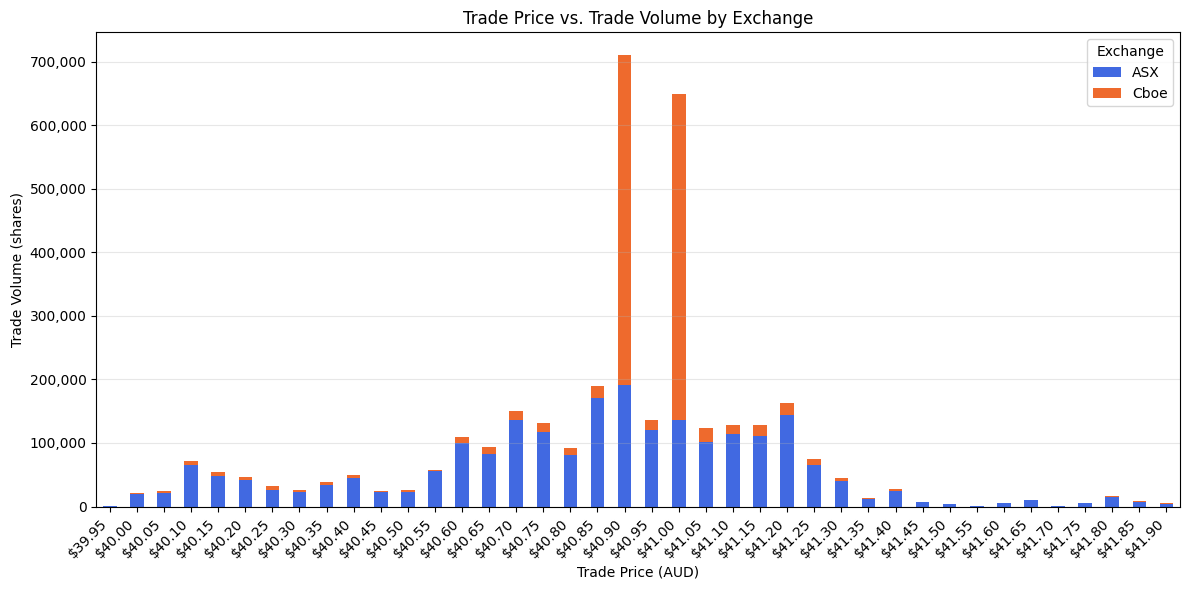

In [206]:
# Define custom colors for ASX and Cboe
exchange_colors = {'ASX': 'royalblue', 'Cboe': "#EE6A2D", 'Other': 'gray'}

# classify exchange
trades_data['Exchange'] = trades_data['#RIC'].apply(
    lambda x: 'ASX' if str(x).endswith('.AX') else ('Cboe' if str(x).endswith('.CHA') else 'Other')
)

# (optional) bin prices to 5c to reduce clutter
price_bin = 0.05
trades_data['PriceBin'] = (trades_data['Price'] / price_bin).round() * price_bin

# aggregate by Exchange × PriceBin with RAW volume
agg_data = trades_data.groupby(['Exchange', 'PriceBin'], as_index=False)['Volume'].sum()

pivot_data = agg_data.pivot(index='PriceBin', columns='Exchange', values='Volume').fillna(0).sort_index()

fig, ax = plt.subplots(figsize=(12,6))
pivot_data.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=[exchange_colors.get(col, '#999999') for col in pivot_data.columns],  # <-- colors applied here
    edgecolor='none'
)
ax.set_xlabel("Trade Price (AUD)")
ax.set_ylabel("Trade Volume (shares)")
ax.set_title("Trade Price vs. Trade Volume by Exchange")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))
ax.set_xticklabels([f"${p:.2f}" for p in pivot_data.index], rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Trade Count x Time (15 Min Intervals): (i) Stacked Bar Chart (ii) Line Plot

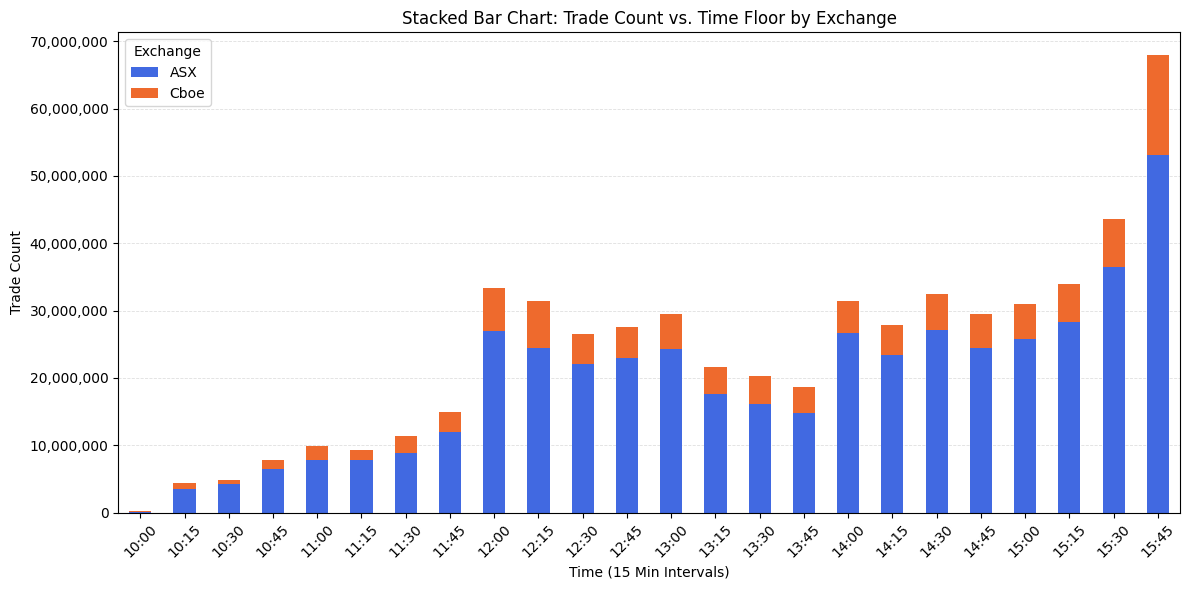

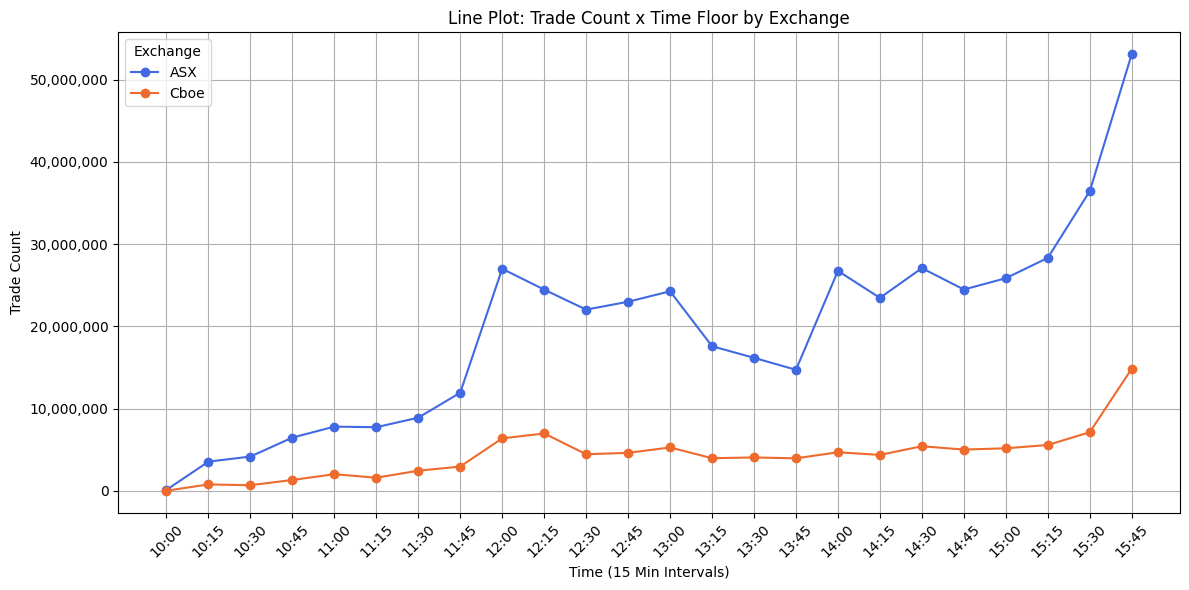

In [205]:
# Define custom colors for ASX and Cboe
exchange_colors = {'ASX': 'royalblue', 'Cboe': "#EE6A2D", 'Other': 'gray'}

# Create a 'time_only' column with 15-minute intervals formatted as HH:MM
trades_data['time_floor'] = trades_data['Date-Time'].dt.floor('15min')
trades_data['value_traded'] = trades_data['Price'] * trades_data['Volume']
trades_data['value_traded'] = pd.to_numeric(trades_data['value_traded'], errors='coerce')
trades_data['time_only'] = trades_data['time_floor'].dt.strftime('%H:%M')

# Group by Exchange and time_only to sum the trade_count
agg_trade_count = trades_data.groupby(['Exchange', 'time_only'], as_index=False)['trade_count'].sum()

# Pivot the aggregated data so that each 'time_only' becomes a row and each Exchange a column
pivot_trade_count = agg_trade_count.pivot(index='time_only', columns='Exchange', values='trade_count').fillna(0)

# Stacked Bar Chart: Trade Count x Time (15 min intervals)
fig, ax = plt.subplots(figsize=(12, 6))
pivot_trade_count.plot(kind='bar', stacked=True, ax=ax, color=[exchange_colors[col] for col in pivot_trade_count.columns])

# Set axis labels and title
ax.set_xlabel("Time (15 Min Intervals)")
ax.set_ylabel("Trade Count")
ax.set_title("Stacked Bar Chart: Trade Count vs. Time Floor by Exchange")

# Format y-axis to show numbers with commas (e.g., 10,000)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))

# Rotate x-axis labels for better readability
ax.set_xticklabels(pivot_trade_count.index, rotation=45)

# Add legend and grid
ax.legend(title="Exchange")
plt.tight_layout()
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
ax.xaxis.grid(False)

# Show the final plot
plt.show()

# Line Plot: Trade Count x Time (15 min intervals)
positions = list(range(len(pivot_trade_count.index)))

fig2, ax2 = plt.subplots(figsize=(12, 6))
for exchange in pivot_trade_count.columns:
    ax2.plot(positions, pivot_trade_count[exchange], marker='o', label=exchange, color=exchange_colors[exchange])

# Set axis labels and title
ax2.set_xlabel("Time (15 Min Intervals)")
ax2.set_ylabel("Trade Count")
ax2.set_title("Line Plot: Trade Count x Time Floor by Exchange")

# Format y-axis to show numbers with commas
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))

# Set tick positions using FixedLocator
ax2.xaxis.set_major_locator(FixedLocator(positions))

# Set tick labels using FixedFormatter
ax2.xaxis.set_major_formatter(FixedFormatter(pivot_trade_count.index))

# Rotate x-tick labels for readability
plt.setp(ax2.get_xticklabels(), rotation=45)

# Add legend and grid
ax2.legend(title="Exchange")
ax2.grid(True)
plt.tight_layout()

# Show the final plot
plt.show()

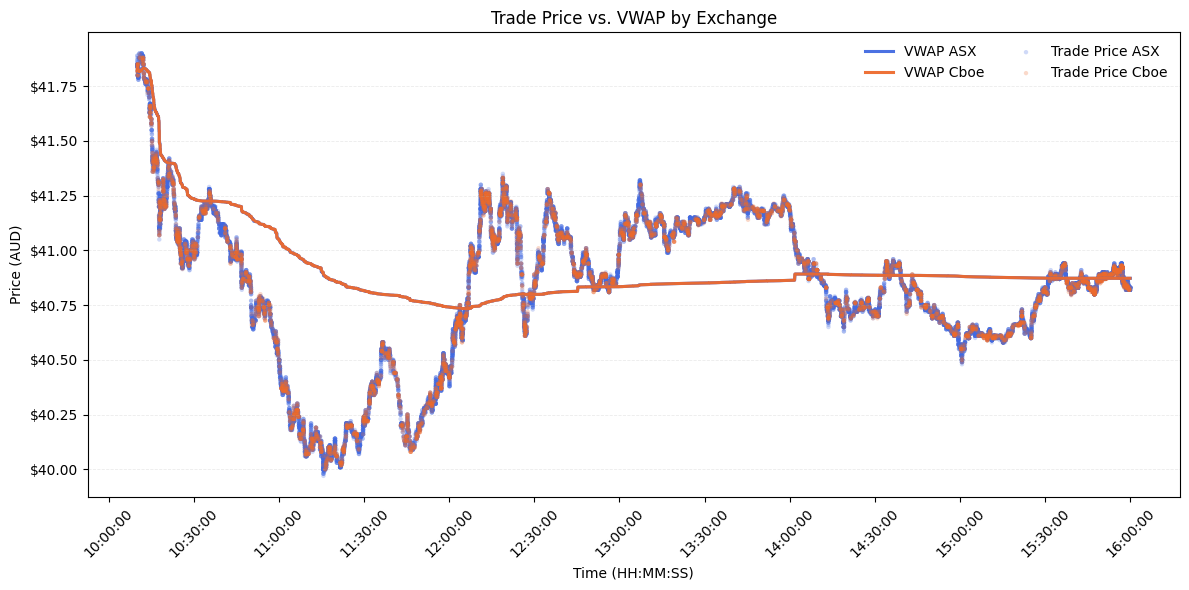

In [204]:
# --- Prep ---
# Consistent venue labels
trades_data['Exchange'] = trades_data['#RIC'].apply(
    lambda x: 'ASX' if str(x).endswith('.AX') else ('Cboe' if str(x).endswith('.CHA') else 'Other')
)

# Cumulative VWAP
trades_data['cum_value_traded'] = trades_data['value_traded'].cumsum()
trades_data['cum_volume']       = trades_data['Volume'].cumsum()
trades_data['cum_vwap']         = trades_data['cum_value_traded'] / trades_data['cum_volume']

# Time-only for plotting
trades_data['datetime_only'] = pd.to_datetime(
    trades_data['Date-Time'].dt.strftime('%H:%M:%S'), format="%H:%M:%S"
)

asx = trades_data[trades_data['Exchange'] == 'ASX'].copy()
cboe = trades_data[trades_data['Exchange'] == 'Cboe'].copy()

# --- Styling ---
palette = {'ASX': 'royalblue', 'Cboe': '#EE6A2D'}  # royal blue + red-orange
vwap_style = {'lw': 2.2, 'alpha': 0.95}            # thicker line for VWAP
trade_style = {'s': 10, 'alpha': 0.25}             # lighter dots for trades

fig, ax = plt.subplots(figsize=(12, 6))

# VWAP lines (much easier to read than dense scatter)
ax.plot(asx['datetime_only'],  asx['cum_vwap'],  color=palette['ASX'],  **vwap_style, label='VWAP ASX')
ax.plot(cboe['datetime_only'], cboe['cum_vwap'], color=palette['Cboe'], **vwap_style, label='VWAP Cboe')

# Trade-price scatter (subtle)
ax.scatter(asx['datetime_only'],  asx['Price'],  color=palette['ASX'],  edgecolor='none', **trade_style, label='Trade Price ASX')
ax.scatter(cboe['datetime_only'], cboe['Price'], color=palette['Cboe'], edgecolor='none', **trade_style, label='Trade Price Cboe')

# Axes formatting
ax.set_title("Trade Price vs. VWAP by Exchange")
ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Price (AUD)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 30]))
for label in ax.get_xticklabels():
    label.set_rotation(45)

# Only horizontal gridlines, light
ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.25)
ax.xaxis.grid(False)

# Dollar format on y
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:.2f}'))

# Cleaner legend (single row)
ax.legend(ncol=2, frameon=False)

plt.tight_layout()
plt.show()

### Scatter Plot: Trade Prices, Bid Prices & Ask Prices vs. Time

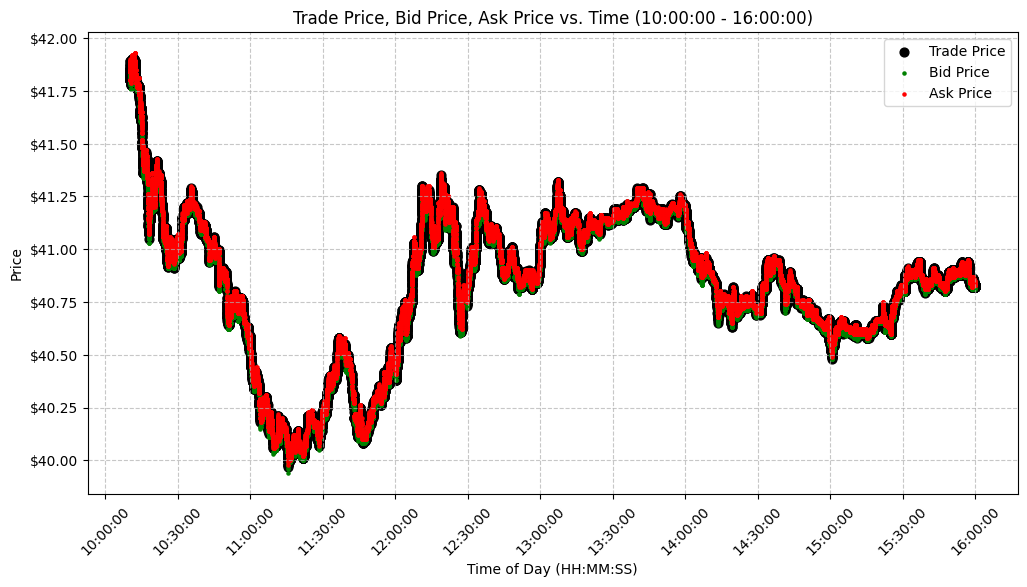

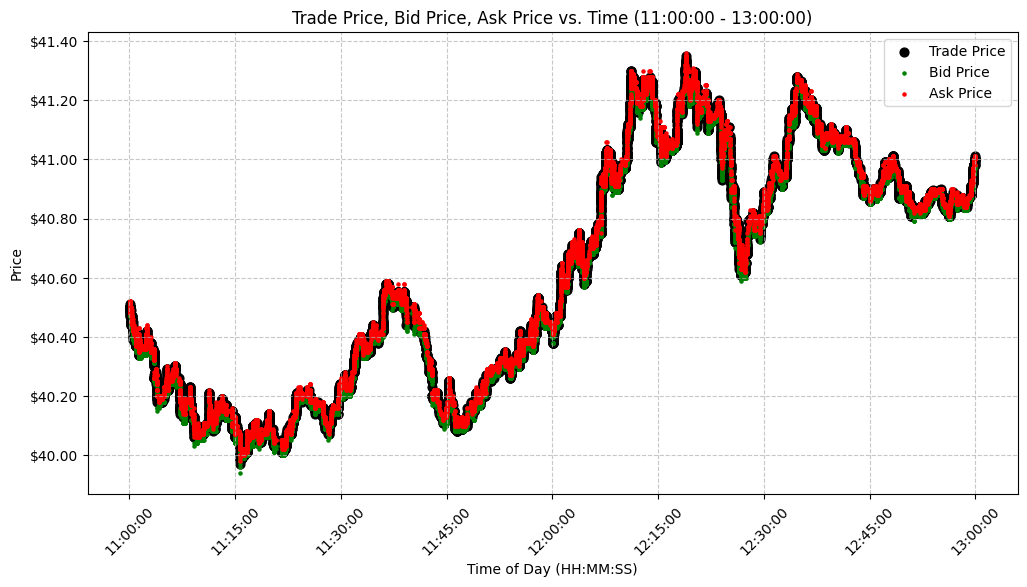

In [183]:
# Define time ranges for filtering
time_ranges = [("10:00:00", "16:00:00"), ("11:00:00", "13:00:00")]

# Ensure time_floor is in datetime format
trades_data['time_floor'] = pd.to_datetime(trades_data['time_floor'])
trades_data['datetime_only'] = pd.to_datetime(trades_data['Date-Time'].dt.strftime('%H:%M:%S'), format="%H:%M:%S")

# Function to filter data based on time range
def filter_time_range(df, start, end):
    start_dt = datetime.strptime(start, "%H:%M:%S")
    end_dt = datetime.strptime(end, "%H:%M:%S")
    return df[(df['datetime_only'] >= start_dt) & (df['datetime_only'] <= end_dt)].reset_index(drop=True)

# Function to format price axis as dollars and cents
def format_price(x, _):
    return f"${x:.2f}"

# Function to determine time grid spacing & ensure axis starts at given times
def get_time_intervals(start, end):
    start_dt = datetime.strptime(start, "%H:%M:%S")
    end_dt = datetime.strptime(end, "%H:%M:%S")
    total_minutes = (end_dt - start_dt).seconds // 60

    # Choose an appropriate interval based on the total time span
    if total_minutes > 180:  
        interval = 30  # More than 3 hours → 30-minute ticks
    elif total_minutes > 60:  
        interval = 15  # 1-3 hours → 15-minute ticks
    else:                   
        interval = 5   # Less than 1 hour → 5-minute ticks

    # Generate time intervals **starting at the exact given start time**
    return pd.date_range(start=start_dt, end=end_dt, freq=f"{interval}min")

# Function to plot trade, bid, and ask prices
def plot_prices(df, title, start, end):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot Trade, Bid, and Ask Prices
    ax.scatter(df['datetime_only'], df['Price'], color='black', marker='o', label='Trade Price', s=40)
    ax.scatter(df['datetime_only'], df['Bid Price'], color='green', marker='o', label='Bid Price', s=5)
    ax.scatter(df['datetime_only'], df['Ask Price'], color='red', marker='o', label='Ask Price', s=5)

    # Formatting
    ax.set_xlabel("Time of Day (HH:MM:SS)")
    ax.set_ylabel("Price")
    ax.set_title(title)
    ax.legend()

    # Format y-axis to show prices in dollars and cents
    ax.yaxis.set_major_formatter(FuncFormatter(format_price))

    # Generate time intervals ensuring the axis starts at `start`
    time_intervals = get_time_intervals(start, end)

    # Set x-axis tick positions **starting at the exact requested time**
    ax.set_xticks(time_intervals)
    ax.set_xticklabels(time_intervals.strftime("%H:%M:%S"), rotation=45)

    # Enable both vertical and horizontal gridlines
    ax.grid(True, which='major', linestyle='--', alpha=0.7)

    plt.show()

# Generate plots for each time range
for start, end in time_ranges:
    filtered_data = filter_time_range(trades_data, start, end)
    if not filtered_data.empty:
        plot_prices(filtered_data, f"Trade Price, Bid Price, Ask Price vs. Time ({start} - {end})", start, end)
    else:
        print(f"No data available for time range {start} - {end}")


## 2.(b) Microstructure Analysis: Orders

### Order Book Analysis: (i) Bid Ask Spread; (ii) Bid/Ask Depth; (iii) Order Depth; (iv) Min Available Depth; (v) Order Imbalance

In [184]:
# 1) Detect which order-book levels actually exist in your CSV
level_re = re.compile(r'^L(\d+)-(BidPrice|AskPrice|BidSize|AskSize)$')
levels_found = sorted({int(level_re.match(c).group(1)) for c in depth_data.columns if level_re.match(c)})

if not levels_found:
    raise ValueError("No Lx-* columns found in depth_data.")
print(f"Order book levels detected: {levels_found}")

# 2) Cast only existing columns to numeric (and clean infinities/NaNs)
for L in levels_found:
    for c in [f'L{L}-BidPrice', f'L{L}-AskPrice', f'L{L}-BidSize', f'L{L}-AskSize']:
        depth_data[c] = pd.to_numeric(depth_data.get(c), errors='coerce')
        depth_data[c] = depth_data[c].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3) Compute metrics for available levels
for L in levels_found:
    # Bid–Ask spread ($ and %)
    depth_data[f'BidAskSpread$_L{L}'] = depth_data[f'L{L}-AskPrice'] - depth_data[f'L{L}-BidPrice']
    denom_spread = (depth_data[f'L{L}-BidPrice'] + depth_data[f'L{L}-AskPrice']).replace(0, np.nan)
    depth_data[f'BidAskSpread%_L{L}'] = 100 * 2 * depth_data[f'BidAskSpread$_L{L}'] / denom_spread

    # Cumulative depths up to level L (only using existing levels)
    up_to_L = [k for k in levels_found if k <= L]
    depth_data[f'CumBidDepth_L{L}'] = depth_data[[f'L{k}-BidSize' for k in up_to_L]].sum(axis=1)
    depth_data[f'CumAskDepth_L{L}'] = depth_data[[f'L{k}-AskSize' for k in up_to_L]].sum(axis=1)

    # Order depth at level L
    depth_data[f'OrderDepth_L{L}'] = depth_data[f'L{L}-BidSize'] + depth_data[f'L{L}-AskSize']

    # Minimum available depth (min of cum sides)
    depth_data[f'MinAvailDepth_L{L}'] = depth_data[[f'CumBidDepth_L{L}', f'CumAskDepth_L{L}']].min(axis=1)

    # Imbalance (N and %)
    num = depth_data[f'L{L}-BidSize'] - depth_data[f'L{L}-AskSize']
    den = (depth_data[f'L{L}-BidSize'] + depth_data[f'L{L}-AskSize']).replace(0, np.nan)
    depth_data[f'Imbalance$_L{L}'] = num
    depth_data[f'Imbalance%_L{L}'] = 100 * num / den

# 4) Optional sample output for L1 if present
if 1 in levels_found:
    print("\nOrder Analysis - Sample (L1):")
    print(depth_data[['Date-Time','L1-BidPrice','L1-AskPrice',
                      'BidAskSpread$_L1','BidAskSpread%_L1',
                      'L1-BidSize','L1-AskSize',
                      'CumBidDepth_L1','CumAskDepth_L1',
                      'Imbalance$_L1','Imbalance%_L1',
                      'OrderDepth_L1']].head())

# Optional: cap to the detected levels (already 1..5), then quick sanity checks
assert depth_data['BidAskSpread$_L1'].ge(0).all(), "Spread$ should be ≥ 0"
assert depth_data['Imbalance%_L1'].between(-100, 100).all(), "Imbalance% must be in [-100,100]"

# (nice for printing)
cols = ['Date-Time','L1-BidPrice','L1-AskPrice','BidAskSpread$_L1','BidAskSpread%_L1',
        'L1-BidSize','L1-AskSize','CumBidDepth_L1','CumAskDepth_L1','Imbalance$_L1','Imbalance%_L1','OrderDepth_L1']
print(depth_data[cols].round({'BidAskSpread%_L1':4, 'Imbalance%_L1':2}).head())

Order book levels detected: [1, 2, 3, 4, 5]

Order Analysis - Sample (L1):
                            Date-Time  L1-BidPrice  L1-AskPrice  \
0 2025-09-30 10:10:00.388867492+10:00         41.8        41.84   
1 2025-09-30 10:10:00.389983878+10:00         41.8        41.84   
2 2025-09-30 10:10:00.389983878+10:00         41.8        41.84   
3 2025-09-30 10:10:00.389983878+10:00         41.8        41.84   
4 2025-09-30 10:10:03.059118948+10:00         41.8        41.84   

   BidAskSpread$_L1  BidAskSpread%_L1  L1-BidSize  L1-AskSize  CumBidDepth_L1  \
0              0.04          0.095648         785         256             785   
1              0.04          0.095648         782         256             782   
2              0.04          0.095648         782         256             782   
3              0.04          0.095648         782         256             782   
4              0.04          0.095648         782         256             782   

   CumAskDepth_L1  Imbalance$_L1  I

Plotting BidAskSpread (AUD) for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


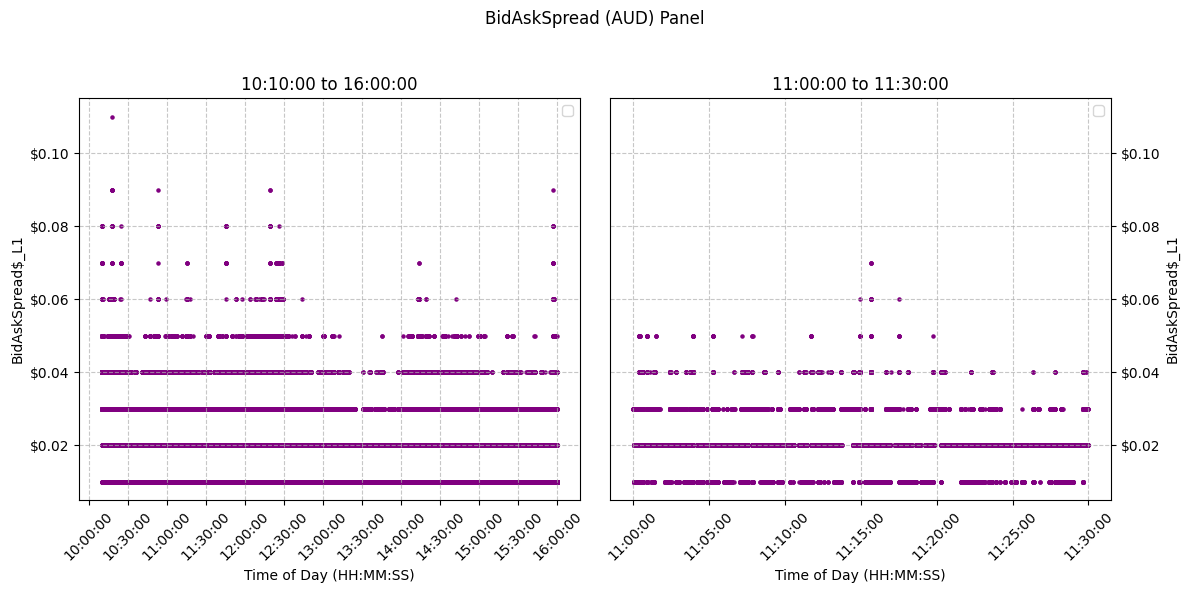

Plotting BidAskSpread (%) for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


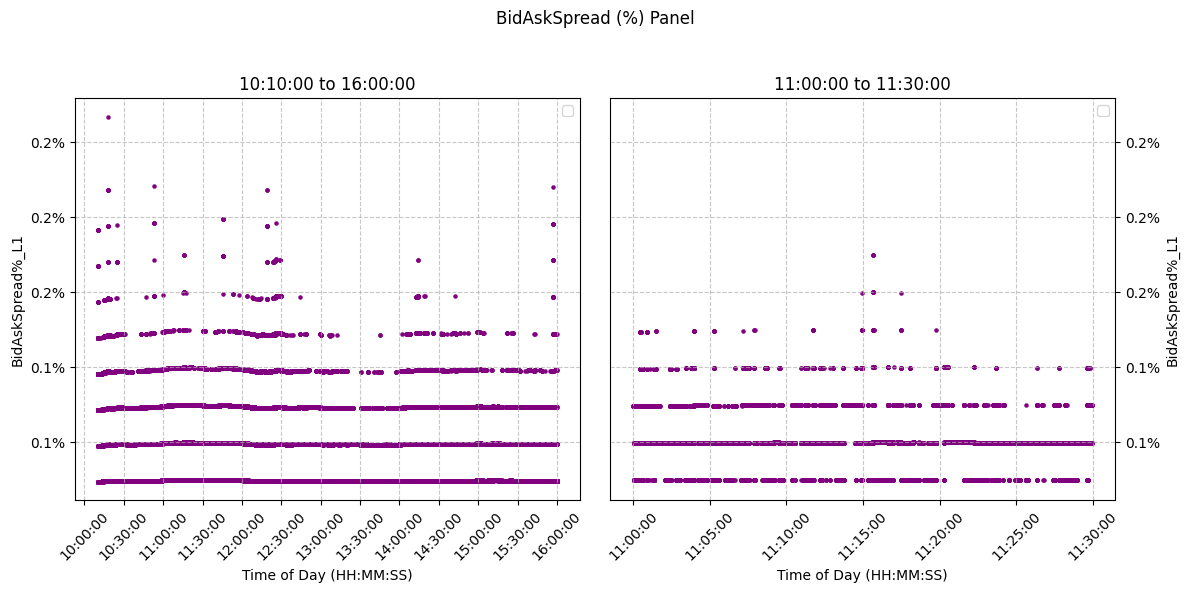

Plotting Cumulative Bid Depth for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


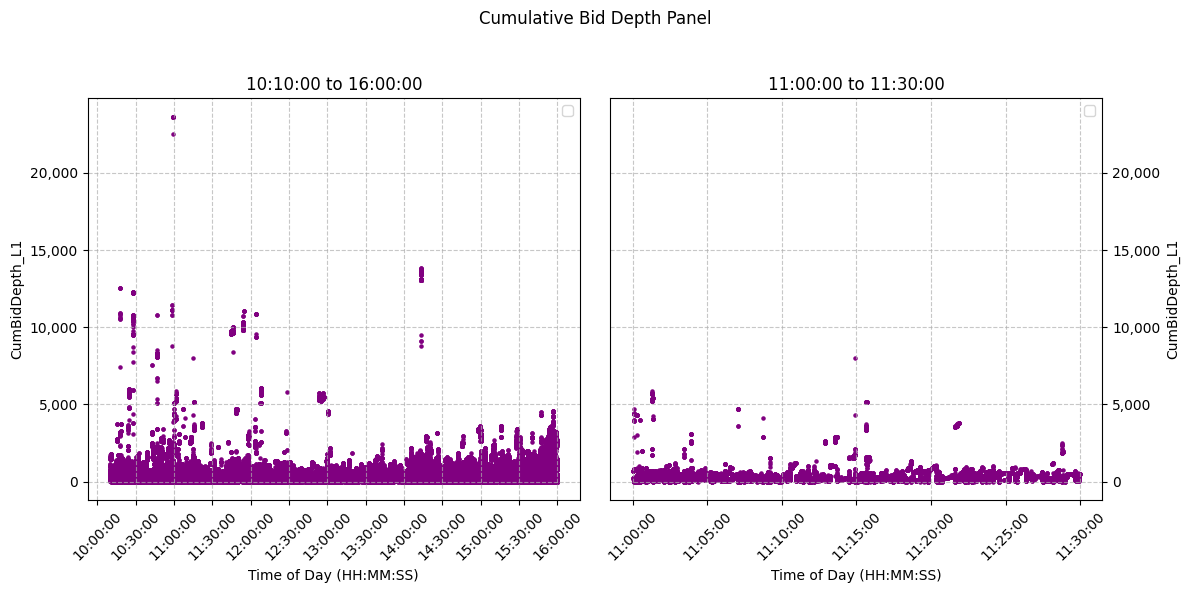

Plotting Cumulative Ask Depth for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


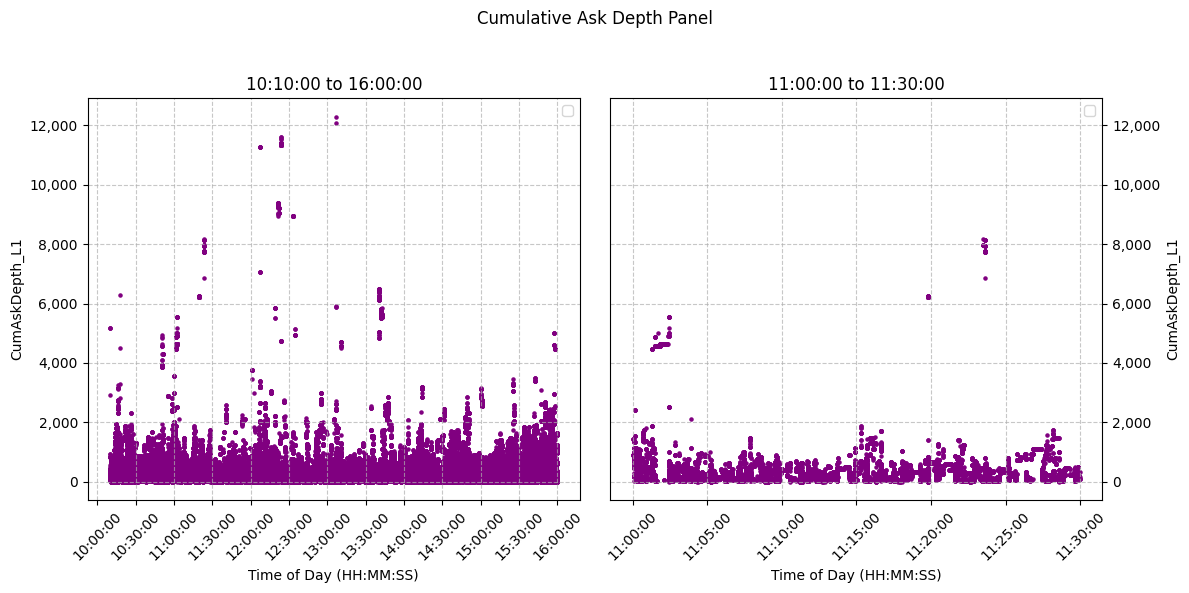

Plotting Order Depth for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


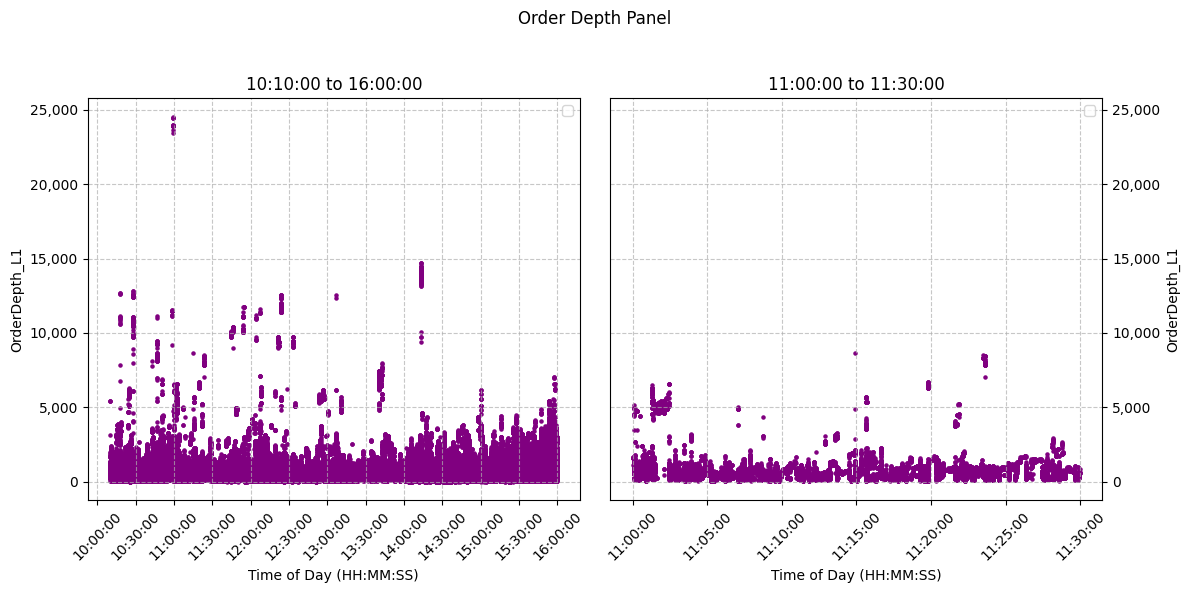

Plotting Min Available Depth for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


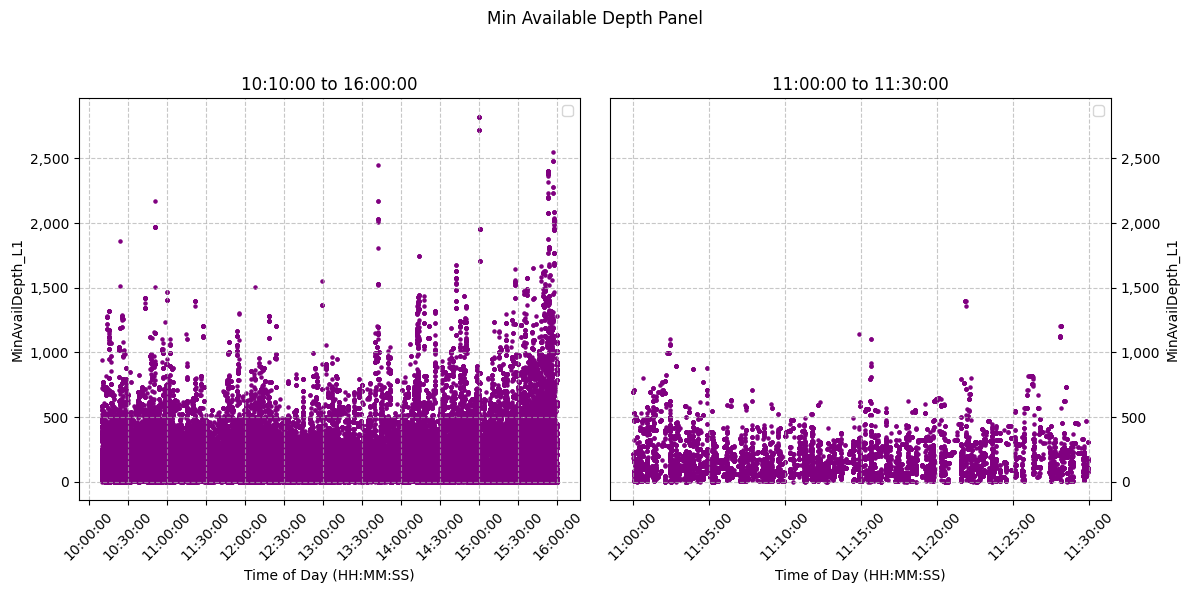

Plotting Order Imbalance (N) for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


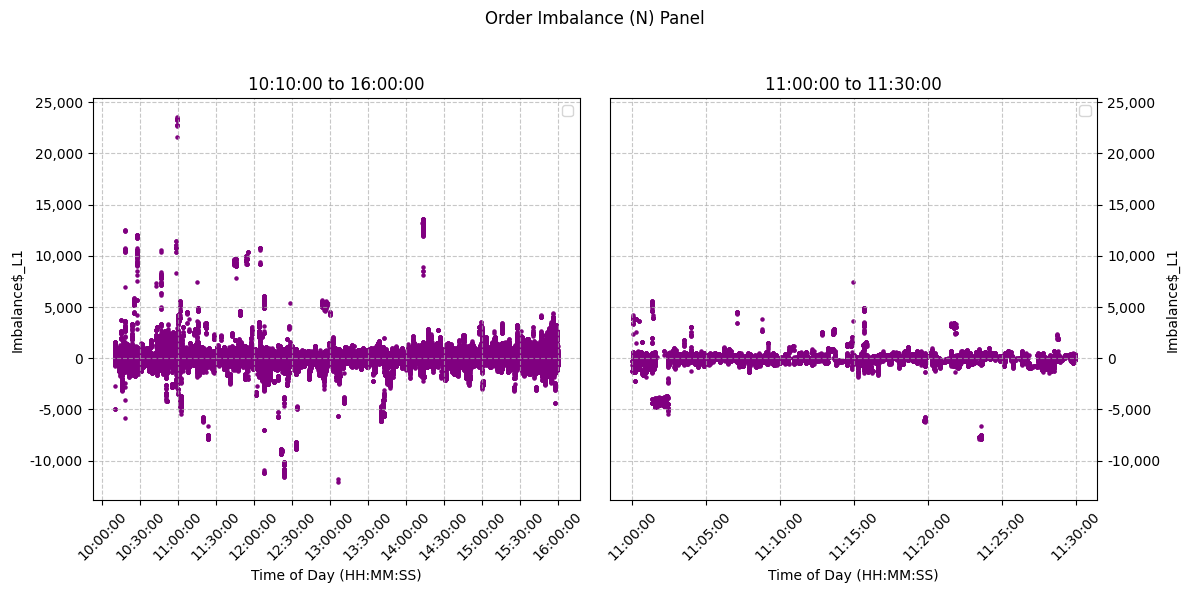

Plotting Order Imbalance (%) for different time ranges in panel:


/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/var/folders/0f/4n4h84q51vqcbqn9r_kns_w40000gn/T/ipykernel_93979/4180187677.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


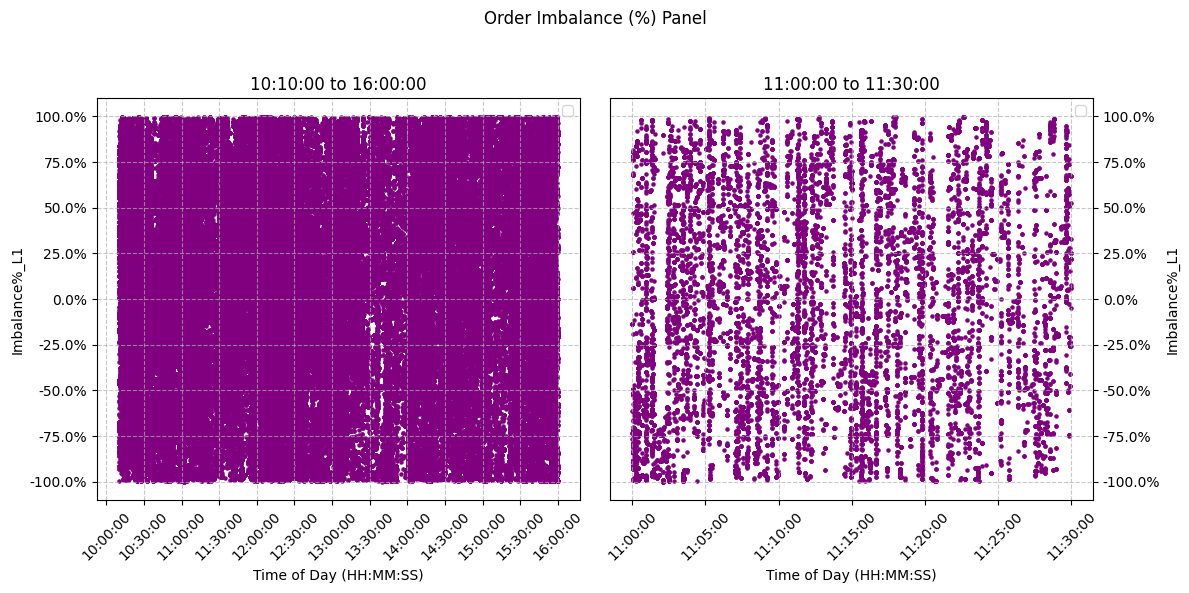

In [215]:
# Ensure 'Date-Time' is in datetime format
depth_data['Date-Time'] = pd.to_datetime(depth_data['Date-Time'])
# Convert 'datetime_only' to datetime object, remove timezone if needed
depth_data['datetime_only'] = depth_data['Date-Time'].dt.tz_localize(None).dt.strftime('%H:%M:%S')
depth_data['datetime_only'] = pd.to_datetime(depth_data['datetime_only'], format="%H:%M:%S")

# Round a given start time to the nearest hour or half-hour (rounding down)
def round_time(start):
    dt = datetime.strptime(start, "%H:%M:%S")
    # For simplicity, we always round down: e.g., 10:05 becomes 10:00, 10:35 becomes 10:30.
    if dt.minute < 30:
        rounded_dt = dt.replace(minute=0, second=0)
    else:
        rounded_dt = dt.replace(minute=30, second=0)
    return rounded_dt.strftime("%H:%M:%S")

# Generate x-axis tick positions starting from the rounded start time
def get_time_intervals(start, end):
    # Parse the original start and end times
    start_dt = datetime.strptime(start, "%H:%M:%S")
    end_dt = datetime.strptime(end, "%H:%M:%S")
    total_minutes = (end_dt - start_dt).seconds // 60

    # Choose tick interval based on the total time span
    if total_minutes > 180:
        interval = 30
    elif total_minutes > 60:
        interval = 15
    else:
        interval = 5

    # Use the rounded start time for tick alignment
    rounded_start = datetime.strptime(round_time(start), "%H:%M:%S")
    return pd.date_range(start=rounded_start, end=end_dt, freq=f"{interval}min")

# Filter data within a time range
def filter_time_range(df, start_str, end_str):
    start_time = datetime.strptime(start_str, "%H:%M:%S").time()
    end_time = datetime.strptime(end_str, "%H:%M:%S").time()
    filtered = df[df['Date-Time'].dt.time.between(start_time, end_time)].reset_index(drop=True)
    return filtered

# Dynamically format the y-axis based on the variable name
def format_y_axis(variable):
    if "Spread" in variable and "$" in variable:
        return FuncFormatter(lambda x, _: f"${x:.2f}")
    elif "%" in variable:
        return FuncFormatter(lambda x, _: f"{x:.1f}%")
    else:
        return FuncFormatter(lambda x, _: f"{int(x):,}")

# Plot order book metrics in panel format
def plot_order_metric_panel(df, order_metric, title, time_ranges):
    n = len(time_ranges)
    fig, axs = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)
    if n == 1:
        axs = [axs]

    for i, (start, end) in enumerate(time_ranges):
        # Get the data points (data still starts at the actual start time)
        filtered_data = filter_time_range(df, start, end)
        # 'datetime_only' is already a datetime64 column for plotting
        axs[i].scatter(filtered_data['datetime_only'], filtered_data[order_metric],
                       color='purple', marker='o', s=5)
        
        axs[i].set_xlabel("Time of Day (HH:MM:SS)")
        axs[i].set_title(f"{start} to {end}")
        axs[i].yaxis.set_major_formatter(format_y_axis(order_metric))
        
        # Generate tick positions starting at the rounded start time
        time_intervals = get_time_intervals(start, end)
        axs[i].set_xticks(time_intervals)
        axs[i].set_xticklabels([t.strftime("%H:%M:%S") for t in time_intervals], rotation=45)
        axs[i].grid(True, which='major', linestyle='--', alpha=0.7)
        axs[i].legend()

        # For the right-hand chart (second panel when n == 2) add y-axis tick labels on the right side.
        if n == 2 and i == 1:
            axs[i].yaxis.tick_right()
            axs[i].yaxis.set_tick_params(labelright=True)

    # Set y-axis label on the leftmost panel
    axs[0].set_ylabel(order_metric)
    # Additionally, if there is more than one panel, set the y-axis label on the rightmost panel as well
    if n > 1:
        axs[-1].set_ylabel(order_metric)
        axs[-1].yaxis.set_label_position("right")
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Define time ranges for filtering
time_ranges = [("10:10:00", "16:00:00"), ("11:00:00", "11:30:00")]
# Define Order Book Metrics to be charted
order_metrics = ['BidAskSpread$_L1', 'BidAskSpread%_L1', 'CumBidDepth_L1', 'CumAskDepth_L1', 
                 'OrderDepth_L1', 'MinAvailDepth_L1', 'Imbalance$_L1', 'Imbalance%_L1']
order_labels = ['BidAskSpread (AUD)', 'BidAskSpread (%)', 'Cumulative Bid Depth', 'Cumulative Ask Depth', 
                'Order Depth', 'Min Available Depth', 'Order Imbalance (N)', 'Order Imbalance (%)']

# Generate plots for each order metric
for metric, label in zip(order_metrics, order_labels):
    print(f"Plotting {label} for different time ranges in panel:")
    plot_order_metric_panel(depth_data, metric, f"{label} Panel", time_ranges)


### Fair Value / Mid Price calculations: (i) Simple; (ii) Volume Weighted; (iii) Spread Crossing; (iv) Min Depth

In [186]:
######################################################################
# Step 1: Fair Value Calculations
# 1. Calculate MidPrice1 (Simple Mid Price)
# 2. Calculate MidPrice2 (Volume Weighted Mid Price)
# 3. Calculate MidPrice3 (Spread Crossing Volume Weighted Mid Price)
# 4. Calculate MidPrice4 (Minimum Depth Volume Weighted Mid Price)
######################################################################

# Ensure 'depth_level' is defined
try:
    depth_level
except NameError:
    depth_level = 1  # Default to level 1 if not defined
    print("Warning: depth_level was not defined. Using depth_level=1.")

# Ensure 'Date-Time' is in datetime format
trades_data['Date-Time'] = pd.to_datetime(trades_data['Date-Time'])
depth_data['Date-Time'] = pd.to_datetime(depth_data['Date-Time'])

# Ensure required columns exist before calculation
required_cols = {f'L1-BidPrice', f'L1-AskPrice'}
if not required_cols.issubset(depth_data.columns):
    raise KeyError(f"Missing required columns: {required_cols - set(depth_data.columns)}")

# 1. Calculate MidPrice1 (Simple Mid Price)
depth_data['MidPrice1L1'] = (depth_data['L1-BidPrice'] + depth_data['L1-AskPrice']) / 2

# 2. Calculate MidPrice2 (Volume Weighted Mid Price)
if {'L1-BidSize', 'L1-AskSize'}.issubset(depth_data.columns):
    depth_data['OrderDepthL1'] = depth_data['L1-BidSize'] + depth_data['L1-AskSize']
    depth_data['MidPrice2L1'] = (
        (depth_data['L1-BidPrice'] * depth_data['L1-BidSize']) +
        (depth_data['L1-AskPrice'] * depth_data['L1-AskSize'])
    ) / depth_data['OrderDepthL1']
else:
    print("Warning: Missing volume data for MidPrice2L1 calculation.")

# 3. Calculate MidPrice3 (Spread Crossing Volume Weighted Mid Price)
if {'L1-BidSize', 'L1-AskSize'}.issubset(depth_data.columns):
    depth_data['MidPrice3L1'] = (
        (depth_data['L1-BidPrice'] * depth_data['L1-AskSize']) +
        (depth_data['L1-AskPrice'] * depth_data['L1-BidSize'])
    ) / depth_data['OrderDepthL1']
else:
    print("Warning: Missing volume data for MidPrice3L1 calculation.")

# 4. Calculate MidPrice4 (Minimum Depth Volume Weighted Mid Price)
price_cols = ['MidPrice1L1']
depth_cols = ['L1-BidSize', 'L1-AskSize']
if set(price_cols + depth_cols).issubset(depth_data.columns):
    weighted_sum = (depth_data['MidPrice1L1'] * (depth_data['L1-BidSize'] + depth_data['L1-AskSize']))
    total_depth = depth_data['L1-BidSize'] + depth_data['L1-AskSize']

    # Print total_depth to check values
    print("\nTotal Depth Values:")
    print(total_depth.head())  # Print the first few values for checking

    # Handle NaN or Inf values in total_depth and weighted_sum
    depth_data['weighted_sum'] = weighted_sum
    depth_data['total_depth'] = total_depth

    # Replace NaN or Inf values in total_depth and weighted_sum with 0 or another value of choice
    depth_data['weighted_sum'] = depth_data['weighted_sum'].replace([np.inf, -np.inf], np.nan).fillna(0)
    depth_data['total_depth'] = depth_data['total_depth'].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Check valid depths (non-zero)
    valid_depth = np.isfinite(depth_data['total_depth']) & (depth_data['total_depth'] > 0)
    valid_weighted_sum = np.isfinite(depth_data['weighted_sum']) & (depth_data['weighted_sum'] > 0)

    # Calculate MidPrice4L1 based on valid depths and weighted sum
    depth_data['MidPrice4L1'] = np.where(valid_depth & valid_weighted_sum, depth_data['weighted_sum'] / depth_data['total_depth'], np.nan)
else:
    print("Warning: Missing columns for MidPrice4L1 calculation.")

# Print a sample of depth_data to verify MidPrices are calculated.
print("\nOrder Data Sample with MidPrices:")
print(depth_data[['Date-Time', 'MidPrice1L1', 'MidPrice2L1', 'MidPrice3L1', 'MidPrice4L1']].head())

# Step 2: Sort Both DataFrames by Date-Time
trades_data = trades_data.sort_values('Date-Time')
depth_data = depth_data.sort_values('Date-Time')

# Step 3: Forward Fill Missing MidPrices Before Merging
depth_data[['MidPrice1L1', 'MidPrice2L1', 'MidPrice3L1', 'MidPrice4L1']] = depth_data[
    ['MidPrice1L1', 'MidPrice2L1', 'MidPrice3L1', 'MidPrice4L1']
].ffill()

# Step 4: Merge Trades with Order Data, including MidPrices
# Use pd.merge_asof to align each trade with the most recent order data from depth_data.
# direction='backward' ensures that for each trade, we find the latest order data that is before or at the trade time.
matched_data = pd.merge_asof(
    trades_data, 
    depth_data, 
    on='Date-Time', 
    direction='backward',
    suffixes=('_trade', '_order')
)

# Rename columns back to original names
midprice_columns = ['MidPrice1L1', 'MidPrice2L1', 'MidPrice3L1', 'MidPrice4L1']
for col in midprice_columns:
    if f"{col}_order" in matched_data.columns:
        matched_data.rename(columns={f"{col}_order": col}, inplace=True)

# Step 5: Print Sample Output for Verification
expected_cols = ['Date-Time', 'Price', 'MidPrice1L1', 'MidPrice2L1', 'MidPrice3L1', 'MidPrice4L1']
missing_cols = [col for col in expected_cols if col not in matched_data.columns]

if not missing_cols:
    print("\nMatched Data Sample (Trades & MidPrices):")
    print(matched_data[expected_cols].head())
else:
    print(f"Warning: The following expected columns are missing in matched_data: {missing_cols}")
    print("\nAvailable columns in matched_data:")
    print(list(matched_data.columns))
    print("\nDetailed Matched Data Sample:")
    print(matched_data.head(10))


Total Depth Values:
0    1041
1    1038
2    1038
3    1038
4    1038
dtype: int64

Order Data Sample with MidPrices:
                            Date-Time  MidPrice1L1  MidPrice2L1  MidPrice3L1  \
0 2025-09-30 10:10:00.388867492+10:00        41.82    41.809837    41.830163   
1 2025-09-30 10:10:00.389983878+10:00        41.82    41.809865    41.830135   
2 2025-09-30 10:10:00.389983878+10:00        41.82    41.809865    41.830135   
3 2025-09-30 10:10:00.389983878+10:00        41.82    41.809865    41.830135   
4 2025-09-30 10:10:03.059118948+10:00        41.82    41.809865    41.830135   

   MidPrice4L1  
0        41.82  
1        41.82  
2        41.82  
3        41.82  
4        41.82  

Matched Data Sample (Trades & MidPrices):
                            Date-Time  Price  MidPrice1L1  MidPrice2L1  \
0 2025-09-30 10:10:07.321784933+10:00  41.82        41.82    41.808620   
1 2025-09-30 10:10:07.655860368+10:00  41.85        41.82    41.808491   
2 2025-09-30 10:10:07.655860368+1

### Scatter Plot: Trade Prices & Simple Mid Prices vs. Time

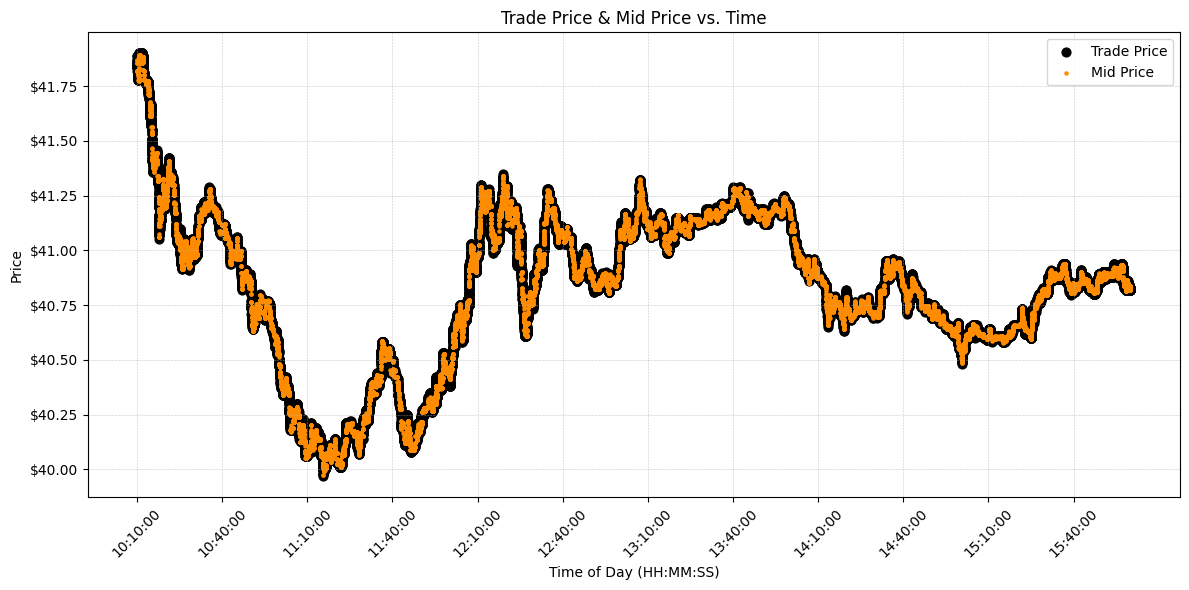

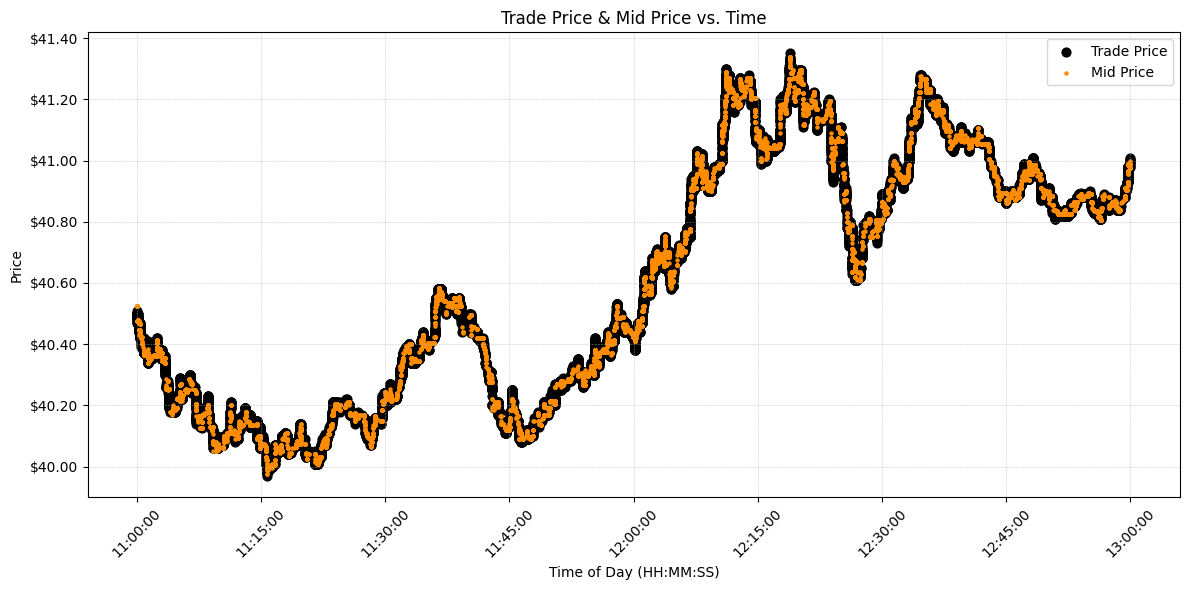

In [187]:
# Ensure 'Date-Time' is in datetime format
matched_data['Date-Time'] = pd.to_datetime(matched_data['Date-Time'])

# Convert 'datetime_only' to a time-like datetime (tz removed)
matched_data['datetime_only'] = matched_data['Date-Time'].dt.tz_localize(None).dt.strftime('%H:%M:%S')
matched_data['datetime_only'] = pd.to_datetime(matched_data['datetime_only'], format="%H:%M:%S")

# Function to filter data by time range
def filter_time_range(df, start, end):
    start_time = datetime.strptime(start, "%H:%M:%S")
    end_time   = datetime.strptime(end,   "%H:%M:%S")
    return df[(df['datetime_only'] >= start_time) & (df['datetime_only'] <= end_time)].reset_index(drop=True)

# Function to format price axis as dollars and cents
def format_price(x, _):
    return f"${x:.2f}"

# Function to determine time grid spacing & ensure axis starts at given times
def get_time_intervals(start, end):
    start_dt = datetime.strptime(start, "%H:%M:%S")
    end_dt   = datetime.strptime(end,   "%H:%M:%S")
    total_minutes = (end_dt - start_dt).seconds // 60
    if total_minutes > 180:
        interval = 30  # >3 hours
    elif total_minutes > 60:
        interval = 15  # 1–3 hours
    else:
        interval = 5   # <1 hour
    return pd.date_range(start=start_dt, end=end_dt, freq=f"{interval}min")

# Function to plot Trade Price vs. Mid Price
def plot_prices(df, title, start, end):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Scatter: trades & mid
    ax.scatter(df['datetime_only'], df['Price'],        color='black',      marker='o', label='Trade Price', s=40)
    ax.scatter(df['datetime_only'], df['MidPrice1L1'],  color='darkorange', marker='o', label='Mid Price',   s=5)

    # Formatting
    ax.set_xlabel("Time of Day (HH:MM:SS)")
    ax.set_ylabel("Price")
    ax.set_title(title)  # <-- no start/end in the title
    ax.legend()
    ax.yaxis.set_major_formatter(FuncFormatter(format_price))

    # Ticks starting exactly at 'start'
    time_intervals = get_time_intervals(start, end)
    ax.set_xticks(time_intervals)
    ax.set_xticklabels(time_intervals.strftime("%H:%M:%S"), rotation=45)

    # Thinner grid
    ax.grid(True, which='major', linestyle='--', alpha=0.7, linewidth=0.4)

    plt.tight_layout()
    plt.show()

# Define time ranges for filtering (use 10:10, not 10:08)
time_ranges = [("10:10:00", "16:00:00"), ("11:00:00", "13:00:00")]

# Generate plots for each time range (titles without the times)
for start, end in time_ranges:
    filtered_data = filter_time_range(matched_data, start, end)
    if not filtered_data.empty:
        plot_prices(filtered_data, "Trade Price & Mid Price vs. Time", start, end)
    else:
        print(f"No data available for time range {start} - {end}")

### Line Plot: Trade Price & Mid Price vs. Time (Categorical), Incorrect Regression (Mid Price vs. Uniform Index)

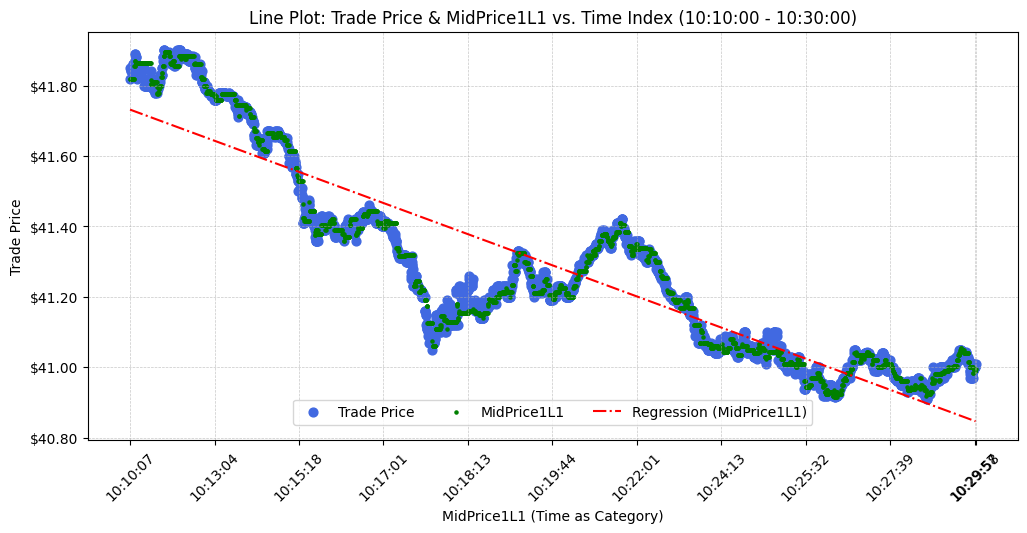

Slope: -0.0003, Intercept: 41.7318, R²: 0.8166


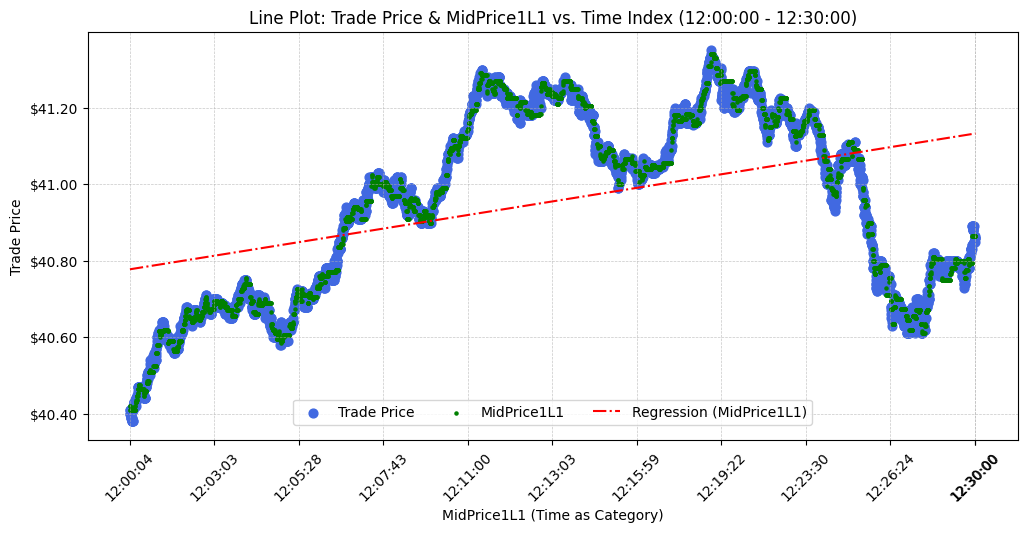

Slope: 0.0001, Intercept: 40.7777, R²: 0.1833


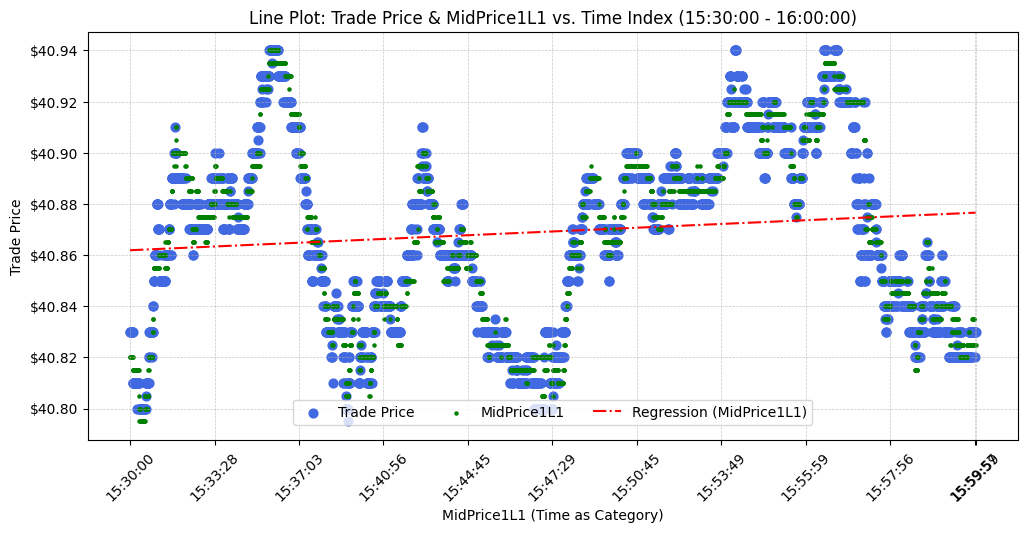

Slope: 0.0000, Intercept: 40.8619, R²: 0.0142


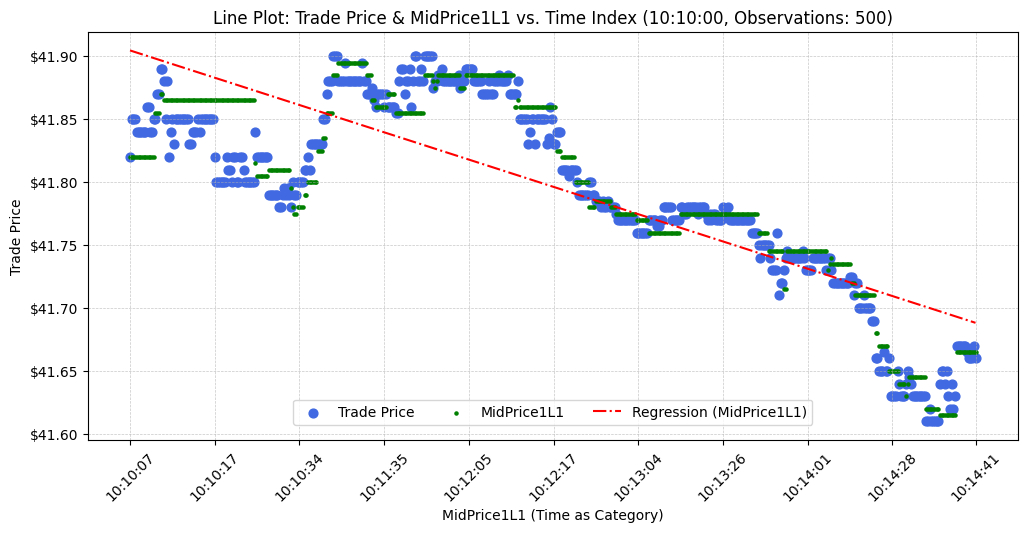

Slope: -0.0004, Intercept: 41.9046, R²: 0.6755


In [208]:
# Preprocess datetime columns as provided
matched_data['Date-Time'] = pd.to_datetime(matched_data['Date-Time'])
matched_data['datetime_only'] = matched_data['Date-Time'].dt.tz_localize(None).dt.strftime('%H:%M:%S')
matched_data['datetime_only'] = pd.to_datetime(matched_data['datetime_only'], format="%H:%M:%S")

# Filter data by start time & end time OR start time & number of observations
def filter_data(df, start_time, end_time=None, num_obs=None):
    df = df.copy()
    start_dt = datetime.strptime(start_time, "%H:%M:%S")
    df_filtered = df[df['datetime_only'] >= start_dt]
    
    if end_time:
        end_dt = datetime.strptime(end_time, "%H:%M:%S")
        df_filtered = df_filtered[df_filtered['datetime_only'] <= end_dt]
    
    if num_obs:
        df_filtered = df_filtered.iloc[:num_obs]
    
    return df_filtered.reset_index(drop=True)

# Format an axis as dollars ($X.XX)
def format_price(x, _):
    return f"${x:.2f}"

# Determine x-axis time intervals, rounded to the next full interval
def get_time_intervals(start, end=None, df_filtered=None):
    start_dt = datetime.strptime(start, "%H:%M:%S")
    
    if end:
        end_dt = datetime.strptime(end, "%H:%M:%S")
    elif df_filtered is not None and not df_filtered.empty:
        last_time = df_filtered['datetime_only'].max()
        total_minutes = (last_time - start_dt).seconds // 60
        interval = 5 if total_minutes < 60 else 15 if total_minutes < 180 else 30
        remainder = total_minutes % interval
        if remainder > 0:
            last_time += timedelta(minutes=(interval - remainder))
        end_dt = last_time
    else:
        end_dt = start_dt
    
    interval = 5 if (end_dt - start_dt).seconds // 60 < 60 else 15 if (end_dt - start_dt).seconds // 60 < 180 else 30
    return pd.date_range(start=start_dt, end=end_dt, freq=f"{interval}min")

# Perform Linear Regression on uniformly spaced indices vs. MidPrice
# (Using the uniform index as independent variable)
def perform_regression_uniform(df, y_col):
    df = df.copy()
    X = np.arange(len(df)).reshape(-1, 1)  # Uniform index as independent variable
    Y = df[y_col].values                  # Dependent variable: MidPrice
    model = LinearRegression()
    model.fit(X, Y)
    regression_line = model.predict(X)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, Y)
    return regression_line, slope, intercept, r_squared

# Add a uniform index (rank) for equal spacing on the x-axis
def add_uniform_index(df):
    df = df.copy()
    df['uniform_index'] = np.arange(len(df))
    return df

# Plot Trade Price vs. MidPrice with Regression, using uniform index for equal spacing.
# The x-axis tick labels are the original time-of-day strings.
def plot_with_regression_uniform(df, start_time, end_time=None, num_obs=None, M=1, L=1):
    midprice_col = f"MidPrice{M}L{L}"
    df_filtered = filter_data(df, start_time, end_time, num_obs)
    if df_filtered.empty:
        print(f"No data available for {start_time} - {end_time or f'{num_obs} observations'}")
        return
    df_uniform = add_uniform_index(df_filtered)
    
    # Perform regression on the uniform index vs. MidPrice.
    regression_line, slope, intercept, r_squared = perform_regression_uniform(df_uniform, midprice_col)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot Trade Price using scatter (black circles, size 40)
    ax.scatter(df_uniform['uniform_index'], df_uniform['Price'], label='Trade Price', color='royalblue', s=40)
    # Plot MidPrice using scatter (dark orange circles, size 40)
    ax.scatter(df_uniform['uniform_index'], df_uniform[midprice_col], label=midprice_col, color='green', s=5)
    # Plot regression line on the uniform index (dark orange dash-dot)
    ax.plot(df_uniform['uniform_index'], regression_line, label=f'Regression ({midprice_col})', color='red', linestyle='-.')
    
    ax.set_xlabel(midprice_col + " (Time as Category)")
    ax.set_ylabel("Trade Price")
    
    # Thin out x-axis tick labels: use every nth observation, ensuring first and last are included.
    x_positions = df_uniform['uniform_index'].values
    labels = df_uniform['datetime_only'].dt.strftime("%H:%M:%S").values
    n = max(1, len(x_positions) // 10)
    tick_positions = x_positions[::n]
    tick_labels = labels[::n]
    if tick_positions[-1] != x_positions[-1]:
        tick_positions = np.append(tick_positions, x_positions[-1])
        tick_labels = np.append(tick_labels, labels[-1])
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45)
    
    ax.yaxis.set_major_formatter(FuncFormatter(format_price))
    
    # Set dynamic title based on filtering
    if end_time:
        ax.set_title(f"Line Plot: Trade Price & {midprice_col} vs. Time Index ({start_time} - {end_time})")
    else:
        ax.set_title(f"Line Plot: Trade Price & {midprice_col} vs. Time Index ({start_time}, Observations: {num_obs})")
       
        # Legend inside gridlines at the bottom-middle
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3)

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.subplots_adjust(bottom=0.2)
    
    plt.show()
    
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R²: {r_squared:.4f}")

# 1) Phase-based windows
windows = [
    ("10:10:00","10:30:00"),  # open discovery
    ("12:00:00","12:30:00"),  # midday steady state
    ("15:30:00","16:00:00"),  # pre-close
]
for s, e in windows:
    # choose ONE plotting function; this line uses the uniform-index version you defined above
    plot_with_regression_uniform(matched_data, s, e, None, M=1, L=1)

# 2) Robustness: fixed N starting at 10:10
plot_with_regression_uniform(matched_data, "10:10:00", None, 500, M=1, L=1)


### Scatter Plot: Trade Price & Mid Price vs. Time, Correct Regression (MidPrice vs. Time)

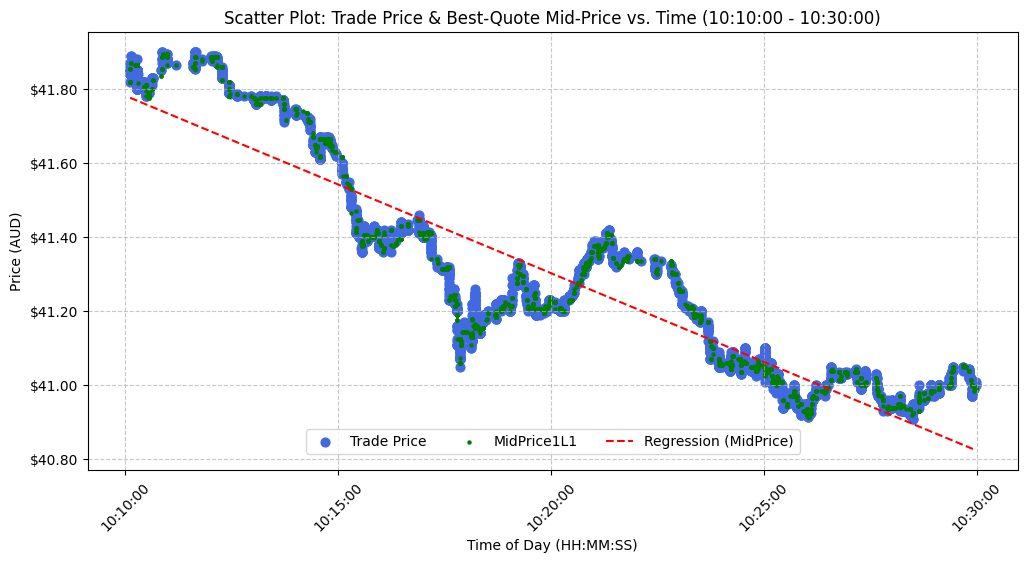

Slope: -0.0008, Intercept: 41.7762, R²: 0.8203


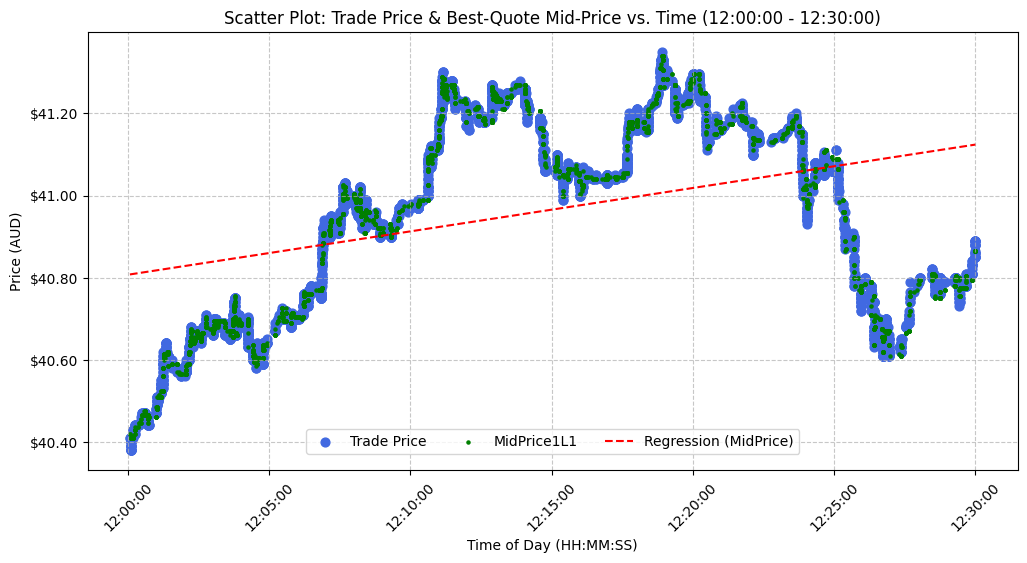

Slope: 0.0002, Intercept: 40.8079, R²: 0.1383


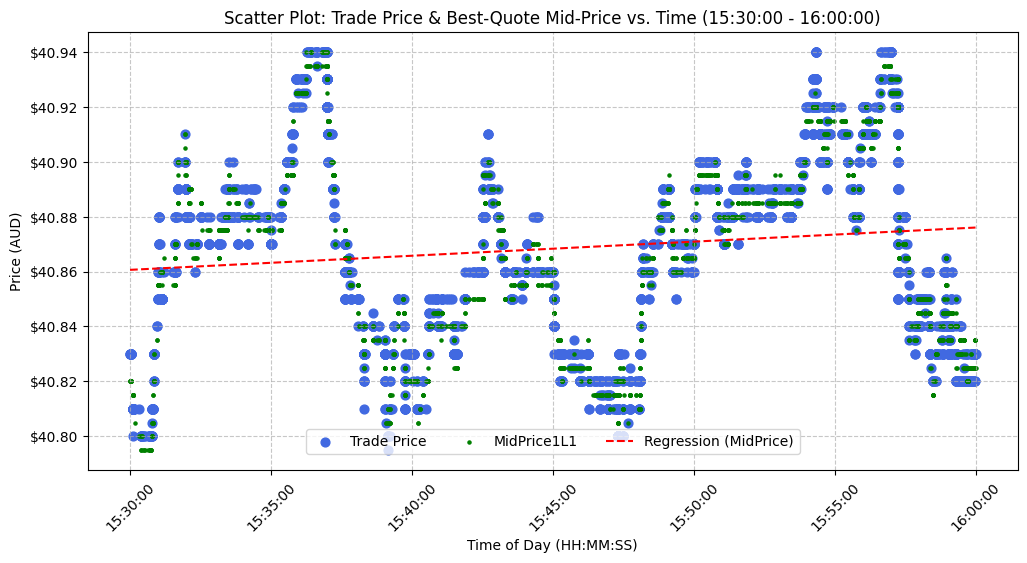

Slope: 0.0000, Intercept: 40.8606, R²: 0.0165


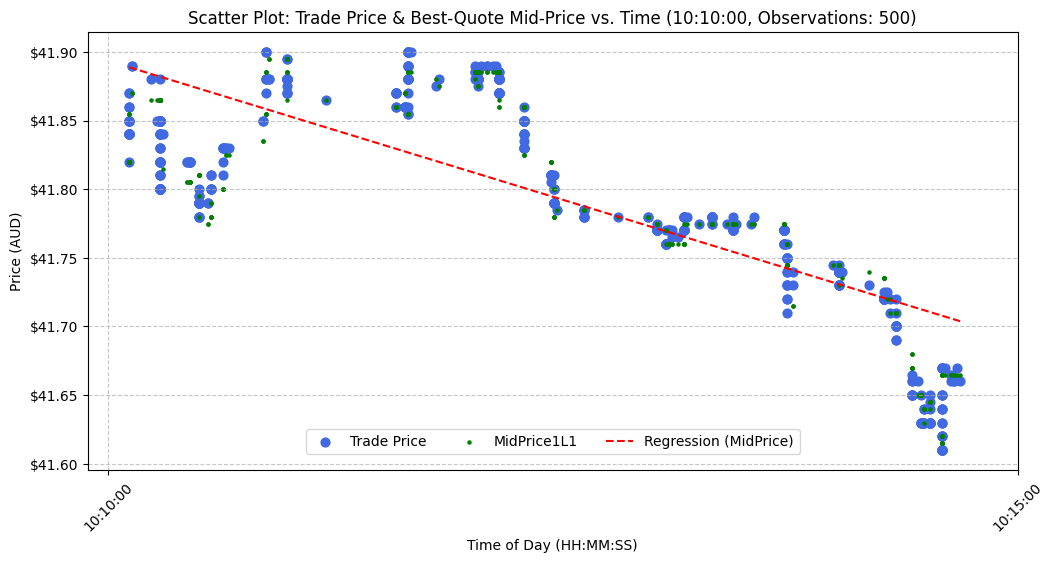

Slope: -0.0007, Intercept: 41.8888, R²: 0.6336


In [209]:
# Ensure 'Date-Time' is in datetime format
matched_data['Date-Time'] = pd.to_datetime(matched_data['Date-Time'])

# Convert 'datetime_only' to datetime object (remove timezone if needed)
matched_data['datetime_only'] = matched_data['Date-Time'].dt.tz_localize(None).dt.strftime('%H:%M:%S')
matched_data['datetime_only'] = pd.to_datetime(matched_data['datetime_only'], format="%H:%M:%S")

# Function to filter data by start time & end time OR start time & number of observations
def filter_data(df, start_time, end_time=None, num_obs=None):
    df = df.copy()
    start_dt = datetime.strptime(start_time, "%H:%M:%S")
    df_filtered = df[df['datetime_only'] >= start_dt]
    
    if end_time:
        end_dt = datetime.strptime(end_time, "%H:%M:%S")
        df_filtered = df_filtered[df_filtered['datetime_only'] <= end_dt]
    
    if num_obs:
        df_filtered = df_filtered.iloc[:num_obs]
    
    return df_filtered.reset_index(drop=True)

# Function to format y-axis as dollars ($X.XX)
def format_price(x, _):
    return f"${x:.2f}"

# Function to determine x-axis time intervals, rounded to the next full interval
def get_time_intervals(start, end=None, df_filtered=None):
    start_dt = datetime.strptime(start, "%H:%M:%S")
    
    if end:
        end_dt = datetime.strptime(end, "%H:%M:%S")
    elif df_filtered is not None and not df_filtered.empty:
        last_time = df_filtered['datetime_only'].max()
        total_minutes = (last_time - start_dt).seconds // 60
        interval = 5 if total_minutes < 60 else 15 if total_minutes < 180 else 30

        # Round up to the next interval
        remainder = total_minutes % interval
        if remainder > 0:
            last_time += timedelta(minutes=(interval - remainder))
        
        end_dt = last_time
    else:
        end_dt = start_dt
    
    interval = 5 if (end_dt - start_dt).seconds // 60 < 60 else 15 if (end_dt - start_dt).seconds // 60 < 180 else 30

    return pd.date_range(start=start_dt, end=end_dt, freq=f"{interval}min")

# Function to perform linear regression on MidPrice vs. Time
def perform_regression(df, x, y):
    df = df.copy()
    df.loc[:, 'time_numeric'] = (df[x] - df[x].min()).dt.total_seconds()
    X = df['time_numeric'].values.reshape(-1, 1)
    Y = df[y].values
    model = LinearRegression()
    model.fit(X, Y)
    regression_line = model.predict(X)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, Y)
    return regression_line, slope, intercept, r_squared

# Function to plot Trade Price vs. MidPrice with regression
def plot_with_regression(df, start_time, end_time=None, num_obs=None, M=1, L=1):
    # Use the pre-existing MidPrice column from matched_data
    df_filtered = filter_data(df, start_time, end_time, num_obs)
    
    if df_filtered.empty:
        print(f"No data available for {start_time} - {end_time or f'{num_obs} observations'}")
        return

    regression_line, slope, intercept, r_squared = perform_regression(df_filtered, 'datetime_only', f'MidPrice{M}L{L}')

    fig, ax = plt.subplots(figsize=(12, 6))

    # Scatter plot for Trade Prices - black circles, size 40
    ax.scatter(df_filtered['datetime_only'], df_filtered['Price'], label='Trade Price', color='royalblue', s=40)
    # Scatter plot for MidPrice - orange circles, size 5
    ax.scatter(df_filtered['datetime_only'], df_filtered[f'MidPrice{M}L{L}'], label=f'MidPrice{M}L{L}', color='green', s=5)

    # Regression line (blue, dashed)
    ax.plot(df_filtered['datetime_only'], regression_line, label='Regression (MidPrice)', color='red', linestyle='--')

    ax.set_xlabel("Time of Day (HH:MM:SS)")
    ax.set_ylabel("Price (AUD)")

    # Set dynamic title based on filtering
    if end_time:
        ax.set_title(f"Scatter Plot: Trade Price & Best-Quote Mid-Price vs. Time ({start_time} - {end_time})")
    else:
        ax.set_title(f"Scatter Plot: Trade Price & Best-Quote Mid-Price vs. Time ({start_time}, Observations: {num_obs})")
       
    # Legend inside gridlines at the bottom-middle
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3)

    # Format y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(format_price))

    # Set x-axis ticks using actual filtered data so the grid starts at the given start_time
    time_intervals = get_time_intervals(start_time, end_time, df_filtered=df_filtered)
    ax.set_xticks(time_intervals)
    ax.set_xticklabels([t.strftime("%H:%M:%S") for t in time_intervals], rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.subplots_adjust(bottom=0.15)  # Adjust bottom spacing

    plt.show()

    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R²: {r_squared:.4f}")

# 1) Phase-based windows (ASX continuous trading)
windows = [
    ("10:10:00","10:30:00"),  # open discovery
    ("12:00:00","12:30:00"),  # midday steady state
    ("15:30:00","16:00:00"),  # pre-close
]
for s, e in windows:
    plot_with_regression(matched_data, s, e, None, M=1, L=1)

# 2) Robustness: fixed N starting at 10:10
plot_with_regression(matched_data, "10:10:00", None, 500, M=1, L=1)

### Scatter Plot: Trade Price vs. Mid Price, Correct Regression (Trade Price vs. Mid Price)

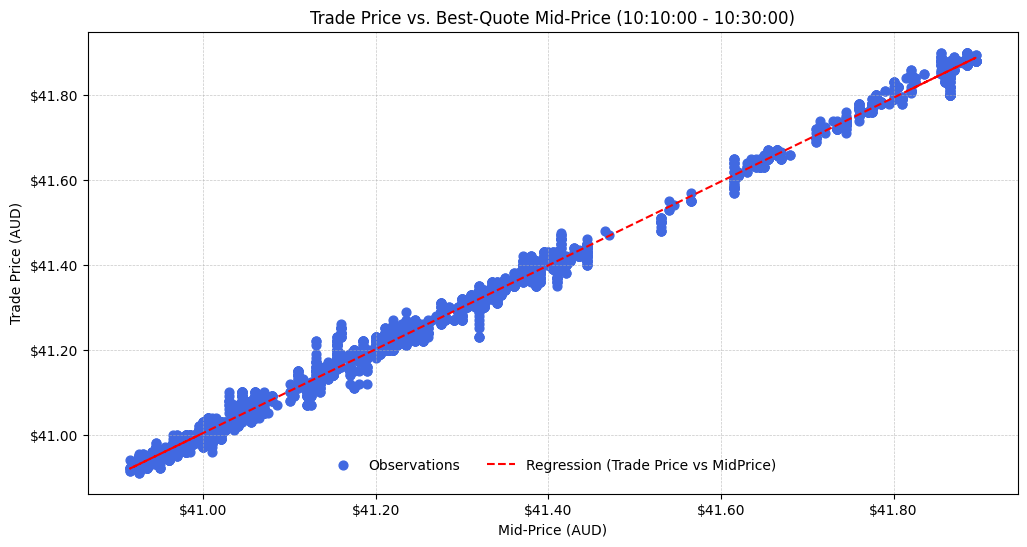

Slope: 0.9879, Intercept: 0.5018, R²: 0.9948


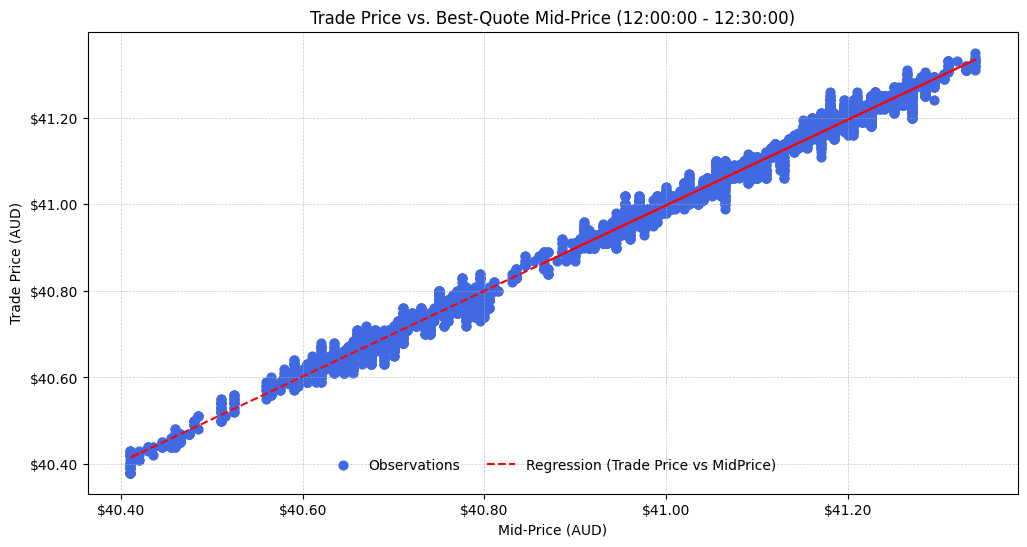

Slope: 0.9888, Intercept: 0.4567, R²: 0.9928


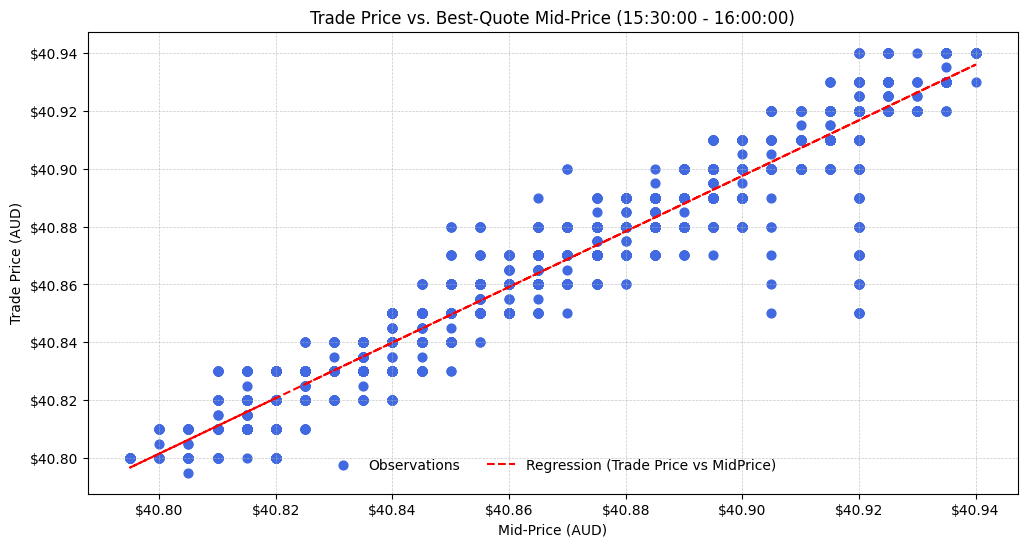

Slope: 0.9591, Intercept: 1.6696, R²: 0.9363


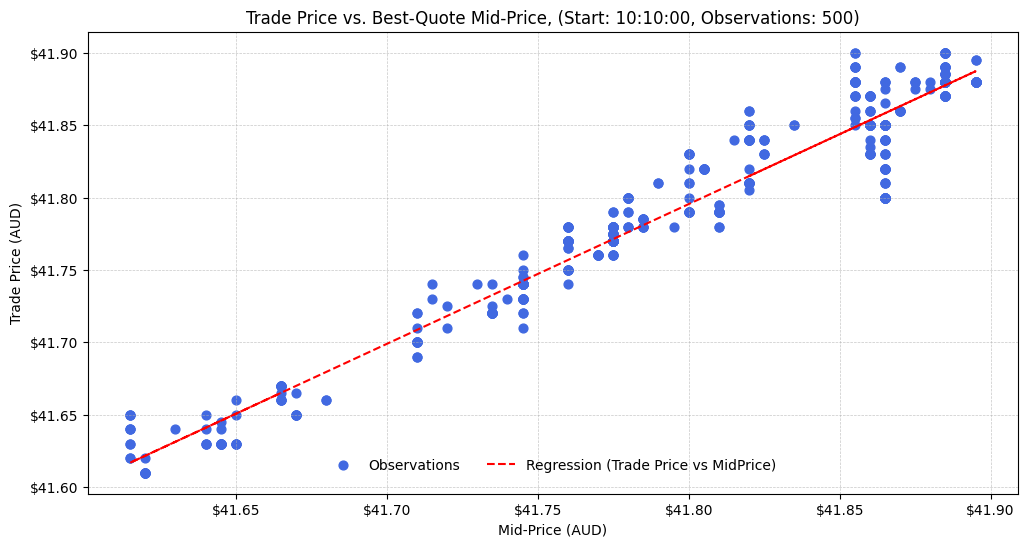

Slope: 0.9654, Intercept: 1.4433, R²: 0.9377


In [213]:
# Ensure 'Date-Time' is in datetime format
matched_data['Date-Time'] = pd.to_datetime(matched_data['Date-Time'])

# Convert 'datetime_only' to datetime object (remove timezone if needed)
matched_data['datetime_only'] = matched_data['Date-Time'].dt.tz_localize(None).dt.strftime('%H:%M:%S')
matched_data['datetime_only'] = pd.to_datetime(matched_data['datetime_only'], format="%H:%M:%S")

# Function to filter data by start time & end time OR start time & number of observations
def filter_data(df, start_time, end_time=None, num_obs=None):
    df = df.copy()
    start_dt = datetime.strptime(start_time, "%H:%M:%S")
    df_filtered = df[df['datetime_only'] >= start_dt]
    
    if end_time:
        end_dt = datetime.strptime(end_time, "%H:%M:%S")
        df_filtered = df_filtered[df_filtered['datetime_only'] <= end_dt]
    
    if num_obs:
        df_filtered = df_filtered.iloc[:num_obs]
    
    return df_filtered.reset_index(drop=True)

# Function to format an axis as dollars ($X.XX)
def format_price(x, _):
    return f"${x:.2f}"

# Function to perform linear regression between Trade Price and MidPrice
def perform_regression(df, midprice_col):
    df = df.copy()
    # Independent variable (MidPrice)
    X = df[midprice_col].values.reshape(-1, 1)
    # Dependent variable (Trade Price)
    Y = df['Price'].values
    model = LinearRegression()
    model.fit(X, Y)
    regression_line = model.predict(X)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, Y)
    return regression_line, slope, intercept, r_squared

# Function to plot Trade Price vs. MidPrice with Regression
def plot_with_regression(df, start_time, end_time=None, num_obs=None, M=1, L=1):
    df_filtered = filter_data(df, start_time, end_time, num_obs)
    
    if df_filtered.empty:
        print(f"No data available for {start_time} - {end_time or f'{num_obs} observations'}")
        return

    midprice_col = f'MidPrice{M}L{L}'
    regression_line, slope, intercept, r_squared = perform_regression(df_filtered, midprice_col)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Scatter plot for Trade Prices & Mid Prices - teal circles, size 40
    ax.scatter(df_filtered[midprice_col], df_filtered['Price'], label='Observations', color='royalblue', s=40)

    # Regression line 
    ax.plot(df_filtered[midprice_col], regression_line, label='Regression (Trade Price vs MidPrice)', color='red', linestyle='--')

    # Set title based on the parameters
    if end_time:
        ax.set_title(f'Trade Price vs. Best-Quote Mid-Price ({start_time} - {end_time})')
    else:
        ax.set_title(f'Trade Price vs. Best-Quote Mid-Price, (Start: {start_time}, Observations: {num_obs})')

    ax.set_xlabel("Mid-Price (AUD)")
    ax.set_ylabel("Trade Price (AUD)")

    # Gridlines for better readability
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Legend inside the chart at the bottom center
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=2, frameon=False)

    # Format y-axis and x-axis
    ax.yaxis.set_major_formatter(FuncFormatter(format_price))
    ax.xaxis.set_major_formatter(FuncFormatter(format_price))

    plt.show()

    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R²: {r_squared:.4f}")

# 1) Phase-based windows
windows = [
    ("10:10:00","10:30:00"),  # open discovery
    ("12:00:00","12:30:00"),  # midday steady state
    ("15:30:00","16:00:00"),  # pre-close
]
for s, e in windows:
    plot_with_regression(matched_data, s, e, None, M=1, L=1)

# 2) Robustness: fixed N starting at 10:10
plot_with_regression(matched_data, "10:10:00", None, 500, M=1, L=1)

## 3. Statistical Analysis

In [191]:
###################################################################################################################
# Calculate the Statistical metrics (MAE, MSE, RMSE, TE) + Correlation between Trades & each MidPrice method
# Determine the MidPrice method with the:
# 1. Lowest Statistical Error Metric
# 2. Highest Correlation.
###################################################################################################################

# Matching trades to orders finding most recent order before the trade occurred
matched_data = pd.merge_asof(trades_data, depth_data, on='Date-Time', direction='backward', suffixes=('_trade', '_order'))

# Define the MidPrice methods to be used in the analysis
midprice_methods = ['MidPrice1L', 'MidPrice2L', 'MidPrice3L', 'MidPrice4L']

# Set the reference price equal to executed / actual Trades
reference_price = matched_data['Price']

# Dictionary to store DataFrames of each MidPrice calculation
metrics_dfs = {}

# Loop over each MidPrice calculation method
for method in midprice_methods:
    metrics_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'TE', 'Correlation'])

    for level in range(1, depth_level+1):
        midprice_col = f'{method}{level}'

        if midprice_col in depth_data.columns:
            # Calculate statistical metrics
            mae = np.mean(np.abs(matched_data[midprice_col] - reference_price))
            mse = np.mean((matched_data[midprice_col] - reference_price) ** 2)
            rmse = np.sqrt(mse)
            te = np.std(matched_data[midprice_col] - reference_price)
            correlation = matched_data[midprice_col].corr(reference_price)

            # Store in DataFrame
            metrics_df[f'L{level}'] = [mae, mse, rmse, te, correlation]

    # Save DataFrame in dictionary
    metrics_dfs[method] = metrics_df

# Print all DataFrames
for method, df in metrics_dfs.items():
    print(f"\nMetrics for {method}:\n")
    print(df)

# Dictionary to store average metric values for each midprice calculation
average_metrics = {}

# Compute the average value of each metric across all levels (1-10) for each method
for method, df in metrics_dfs.items():
    average_metrics[method] = df.mean(axis=1)  # Compute mean across columns (levels)

# Convert to DataFrame for easy analysis
average_metrics_df = pd.DataFrame(average_metrics)

# Dictionary to store the best-performing methods for each metric
best_methods = {}

# Find the method with the lowest MAE, MSE, RMSE, TE
for metric in ['MAE', 'MSE', 'RMSE', 'TE']:
    best_method = average_metrics_df.loc[metric].idxmin()  # Method with lowest value
    best_value = average_metrics_df.loc[metric, best_method]
    best_methods[metric] = (best_method, best_value)

# Find the method with the highest correlation
best_corr_method = average_metrics_df.loc['Correlation'].idxmax()
best_corr_value = average_metrics_df.loc['Correlation', best_corr_method]
best_methods['Correlation'] = (best_corr_method, best_corr_value)

# Convert results to a summary DataFrame
summary_df = pd.DataFrame.from_dict(best_methods, orient='index', columns=['Best Method', 'Average Value'])

# Display the summary
print("\nBest MidPrice Calculation Methods:")
print(summary_df)


Metrics for MidPrice1L:

                   L1
MAE          0.011489
MSE          0.000241
RMSE         0.015512
TE           0.015512
Correlation  0.998973

Metrics for MidPrice2L:

                   L1
MAE          0.012933
MSE          0.000295
RMSE         0.017170
TE           0.017156
Correlation  0.998745

Metrics for MidPrice3L:

                   L1
MAE          0.011331
MSE          0.000246
RMSE         0.015690
TE           0.015672
Correlation  0.998951

Metrics for MidPrice4L:

                   L1
MAE          0.011489
MSE          0.000241
RMSE         0.015512
TE           0.015512
Correlation  0.998973

Best MidPrice Calculation Methods:
            Best Method  Average Value
MAE          MidPrice3L       0.011331
MSE          MidPrice1L       0.000241
RMSE         MidPrice1L       0.015512
TE           MidPrice1L       0.015512
Correlation  MidPrice1L       0.998973


In [192]:
# ---- small helper: pretty print + optional save ----
def _print_table(title, df, round_to=3):
    print(f"\n{title}")
    display(df.round(round_to))

# -------- Table A — Microstructure Summary (L1) --------
table_a = None
need = {'L1-BidPrice','L1-AskPrice','L1-BidSize','L1-AskSize'}
if need.issubset(depth_data.columns):
    dd = depth_data.dropna(subset=list(need)).copy()
    dd['Spread_$']   = dd['L1-AskPrice'] - dd['L1-BidPrice']
    dd['Spread_bps'] = 10000 * dd['Spread_$'] / ((dd['L1-AskPrice'] + dd['L1-BidPrice'])/2)
    dd['OrderDepth'] = dd['L1-BidSize'] + dd['L1-AskSize']
    dd['Imbalance_N'] = dd['L1-BidSize'] - dd['L1-AskSize']
    dd['Imbalance_%'] = 100 * dd['Imbalance_N'] / dd['OrderDepth'].replace(0, np.nan)

    table_a = pd.DataFrame({
        'Median L1 Spread ($)':   [dd['Spread_$'].median()],
        'Median L1 Spread (bps)': [dd['Spread_bps'].median()],
        'Median L1 Bid Size':     [dd['L1-BidSize'].median()],
        'Median L1 Ask Size':     [dd['L1-AskSize'].median()],
        'Median L1 Order Depth':  [dd['OrderDepth'].median()],
        'Median Imbalance (N)':   [dd['Imbalance_N'].median()],
        'Median Imbalance (%)':   [dd['Imbalance_%'].median()],
    })
    _print_table("Table A — Microstructure Summary (L1):", table_a)
else:
    print("Table A skipped: missing L1 columns in depth_data.")

# -------- Table B — Venue Summary --------
table_b = None
if '#RIC' in trades_data.columns and 'Volume' in trades_data.columns:
    td = trades_data.copy()
    td['Venue'] = td['#RIC'].apply(lambda x: 'ASX' if str(x).endswith('.AX') else ('Cboe' if str(x).endswith('.CHA') else 'Other'))
    td['Volume'] = pd.to_numeric(td['Volume'], errors='coerce')

    table_b = (td.groupby('Venue')
                 .agg(Trades=('Price','count'),
                      Volume=('Volume','sum'),
                      MedianTradeSize=('Volume','median'))
                 .reset_index())
    table_b['Share_%'] = 100 * table_b['Trades'] / table_b['Trades'].sum()
    _print_table("Table B — Venue Summary (10:10–16:00):", table_b, round_to=2)
else:
    print("Table B skipped: trades_data missing #RIC or Volume.")

# -------- Table C — Fair-Value Accuracy (L1) --------
table_c = None
meths = ['MidPrice1L1','MidPrice2L1','MidPrice3L1','MidPrice4L1']
present = [m for m in meths if m in matched_data.columns]
if present:
    md = matched_data.dropna(subset=['Price'] + present).copy()
    rows = []
    for m in present:
        err  = md[m] - md['Price']
        mae  = np.abs(err).mean()
        rmse = np.sqrt((err**2).mean())
        corr = md[m].corr(md['Price'])
        rows.append((m, mae, rmse, corr))
    table_c = pd.DataFrame(rows, columns=['Method','MAE','RMSE','Correlation']).sort_values('RMSE')
    _print_table("Table C — Fair-Value Accuracy (vs Trade Price), L1:", table_c, round_to=6)

    # One-line “best by metric”
    best_mae  = table_c.loc[table_c['MAE'].idxmin(), 'Method']
    best_rmse = table_c.loc[table_c['RMSE'].idxmin(), 'Method']
    best_corr = table_c.loc[table_c['Correlation'].idxmax(), 'Method']
    print(f"\nBest by MAE: {best_mae} | Best by RMSE: {best_rmse} | Best by Corr: {best_corr}")
else:
    print("Table C skipped: MidPrice L1 columns not found in matched_data.")

table_a['N_Quotes'] = len(depth_data)
table_b['N_Trades'] = table_b.groupby('Venue')['Trades'].transform('sum')  # or add a single N at caption time

# Round columns
fmt_a = {'Median L1 Spread ($)': '{:.2f}', 'Median L1 Spread (bps)': '{:.2f}',
         'Median L1 Bid Size': '{:.0f}', 'Median L1 Ask Size': '{:.0f}',
         'Median L1 Order Depth': '{:.0f}', 'Median Imbalance (%)': '{:.3f}'}
fmt_b = {'Trades':'{:,.0f}','Volume':'{:,.0f}','MedianTradeSize':'{:.0f}','Share_%':'{:.2f}'}
fmt_c = {'MAE':'{:.6f}','RMSE':'{:.6f}','Correlation':'{:.4f}'}

# ---- Save all to one Excel workbook (optional but recommended) ----
with pd.ExcelWriter("Tables_A_B_C.xlsx", engine="xlsxwriter") as xlw:
    if table_a is not None: table_a.to_excel(xlw, sheet_name="Table_A", index=False)
    if table_b is not None: table_b.to_excel(xlw, sheet_name="Table_B", index=False)
    if table_c is not None: table_c.to_excel(xlw, sheet_name="Table_C", index=False)

print("\nSaved tables to Tables_A_B_C.xlsx")



Table A — Microstructure Summary (L1):


,Median L1 Spread ($),Median L1 Spread (bps),Median L1 Bid Size,Median L1 Ask Size,Median L1 Order Depth,Median Imbalance (N),Median Imbalance (%)
0,0.02,4.89,228.0,189.0,483.0,34.0,10.588



Table B — Venue Summary (10:10–16:00):


,Venue,Trades,Volume,MedianTradeSize,Share_%
0,ASX,27563,2233397,36.0,81.67
1,Cboe,6185,1271395,15.0,18.33



Table C — Fair-Value Accuracy (vs Trade Price), L1:


,Method,MAE,RMSE,Correlation
0,MidPrice1L1,0.011489,0.015512,0.998973
3,MidPrice4L1,0.011489,0.015512,0.998973
2,MidPrice3L1,0.011331,0.015690,0.998951
1,MidPrice2L1,0.012933,0.017170,0.998745



Best by MAE: MidPrice3L1 | Best by RMSE: MidPrice1L1 | Best by Corr: MidPrice1L1

Saved tables to Tables_A_B_C.xlsx
